In [1]:
import os, urllib
from PIL import Image
from io import BytesIO
import numpy as np
from skimage.io import imshow
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.rcParams['figure.max_open_warning'] = False
import pandas as pd
import IPython
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
import DeepLabModel
import seaborn as sb
import pandas as pd
from ipywidgets import FloatSlider, interact, fixed, HBox, VBox, Label, Button, Output, IntProgress, FloatProgress, fixed, IntSlider

### Visualization functions

In [16]:
LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])
FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = DeepLabModel.label_to_color_image(FULL_LABEL_MAP)

def show_proposals(task, proposals):
        plt.figure(figsize=(16,9), dpi=300)
        # Finding all the labels that appear in the proposals for the legend
        unique_labels = np.array([], dtype=np.int)
        for p in proposals:
            unique_labels = np.union1d(unique_labels, np.unique(p))
        unique_labels = unique_labels[unique_labels!=255] # We ignore the void label (see VOC2012 docs)
                
        max_cols = len(proposals)+2

        grid_spec = gridspec.GridSpec(1, max_cols, width_ratios= [6] + [6 for i in proposals]+ [2])
        # Show input
        plt.subplot(grid_spec[0])
        plt.imshow(task)
        plt.axis('off')
        plt.title('Input')

        for p, prop in enumerate(proposals):
            plt.subplot(grid_spec[p+1])
            plt.imshow(DeepLabModel.label_to_color_image(prop).astype(np.uint8))
            plt.axis('off')
            plt.title('Model {}'.format(p+1))

        ax = plt.subplot(grid_spec[max_cols-1])
        plt.imshow(
            FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest', aspect=0.3)
        ax.yaxis.tick_right()
        plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
        plt.xticks([], [])
        ax.tick_params(width=0.0)
        plt.grid(False)
        plt.show()

def show_agreement(agreement, i, initial=None):
        labels = [(l,LABEL_NAMES[l]) for l in range(agreement.shape[-1])]
        if initial is None:
            plt.figure(figsize=(16,9), dpi=300)
            for lpos, lab in labels:
                agr = agreement[...,lpos]
                plt.subplot(np.ceil(np.sqrt(len(labels))), np.ceil(np.sqrt(len(labels))), lpos+1)
                plt.title("Agr {}: {}".format(i, lab))
                #plt.set_cmap('gray')
                plt.axis('off')
                plt.imshow(agr)
        else:
            plt.figure(figsize=(3*2,21*2), dpi=400)
            for lpos, lab in labels:
                agr = agreement[...,lpos]
                ini = initial[...,lpos]
                diff = agr-ini
                
                # Normalize the colormap
                cmax = max(np.max(agr), np.max(ini))
                cmin = min(np.min(agr), np.min(ini))
                norm = colors.Normalize(vmin=cmin, vmax=cmax)
                
                plt.subplot(np.ceil(len(labels)), 3, lpos*3+1)
                plt.title("Agr 0: {}".format(lab))
                #plt.set_cmap('gray')
                plt.axis('off')
                im = plt.imshow(ini)
                im.set_norm(norm)
                cb = plt.colorbar(im,fraction=0.046, pad=0.04)
                cb.ax.tick_params(labelsize='xx-small')
                
                plt.subplot(np.ceil(len(labels)), 3, lpos*3+2)
                plt.title("{}".format(i))
                #plt.set_cmap('gray')
                plt.axis('off')
                im = plt.imshow(agr)
                im.set_norm(norm)
                cb = plt.colorbar(im,fraction=0.046, pad=0.04)
                cb.ax.tick_params(labelsize='xx-small')
                
                plt.subplot(np.ceil(len(labels)), 3, lpos*3+3)
                plt.title("Diff")
                #plt.set_cmap('gray')
                plt.axis('off')
                im = plt.imshow(diff)
                cb = plt.colorbar(im,fraction=0.046, pad=0.04)
                cb.ax.tick_params(labelsize='xx-small')

def plot_segmentations(agreements, proposals, step, im_alpha=1.0, seg_alpha=0.7, task=None, save_to=None):
    ''' given an array of agreements of shape [h, w, labels], proposals of shape [agent, h, w, labels]
    and an optional Task image, shows the predictions of the various agents '''
    
    max_cols = 1 + proposals.shape[1]
    
    grid_spec = gridspec.GridSpec(2, max_cols)
    fig = plt.figure(figsize=(25, 10))
    for row, j in enumerate((0, step)):
        for i in range(max_cols):
            plt.subplot(grid_spec[row,i])
            plt.axis('off')
            title = 'Agreement at step {}'.format(j) if i == max_cols-1 else "Agent {} Proposal at step {}".format(i+1, j)
            plt.title(title)
            if task is not None:
                plt.imshow(task, alpha=im_alpha)

            if i==max_cols-1:
                preds = DeepLabModel.label_to_color_image(np.argmax(agreements[j], axis=-1))
            else:
                preds = DeepLabModel.label_to_color_image(np.argmax(proposals[j,i,...], axis=-1))

            # Removing black from the label
            preds = np.dstack((preds, np.any(preds != [0, 0, 0], axis=-1)*255))

            plt.imshow(preds, alpha=seg_alpha)
    plt.tight_layout()
    return fig



        
def view_proposals_tsne(label_id, proposals, agreements=None):
    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA
    def merge_to_dataframe(label_id, proposals, agreements=None):
        ''' Gets a list of proposals and a list of agreements and merge them in a single dataframe. The agreement will be encoded as an agent with id -1'''

        P=np.array(proposals)[...,label_id] # P(roposal) has shape [steps, agents, h, w, label], picking one label
        P=np.transpose(P, axes=[1,0,2,3]) # now has shape [agents, steps, h, w, 1]
        P=P.reshape(P.shape[0], MAX_STEPS, -1) # now has shape [agents, steps, h*w]
        feat_cols = ['pixel'+str(i) for i in range(P.shape[-1])]
        if agreements is not None:
            A=np.array(agreements)[...,label_id] # A[greements] has shape [steps, h, w, label], picking one label
            A=np.expand_dims(A, axis=0) # now has shape [1 (agent), steps, h, w, 1]
            A=A.reshape(A.shape[0], MAX_STEPS, -1) # now has shape [1, steps, h*w]

        frames = list()
        if agreements is not None:
            # First we create a dataframe for the agreement, treating it as a fake agent
            df = pd.DataFrame(A[0], columns=feat_cols).rename_axis(["step"])
            df = df.reset_index()
            df['agent']=-1
            frames.append(df)
        # Do the same for each agent proposal
        for agentid, proposal in enumerate(P):
            df = pd.DataFrame(proposal, columns=feat_cols).rename_axis(["step"])
            df = df.reset_index()
            df['agent']=agentid
            frames.append(df)
        # Merging the dataframes into a single one
        df = frames[0]
        for f, fr in enumerate(frames):
            if f==0:
                continue
            df = df.append(fr)
            
        return df, feat_cols

    df, cols = merge_to_dataframe(label_id, proposals, agreements)
    
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(df[cols].values)

    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1] 
    df['pca-three'] = pca_result[:,2]

    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    
    
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(df[['pca-one', 'pca-two', 'pca-three']].values)

    print('t-SNE done!')
    df['tsne-2d-one'] = tsne_results[:,0]
    df['tsne-2d-two'] = tsne_results[:,1]

    plt.figure(figsize=(16,10))

    sb.lineplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="agent",
        palette=sb.color_palette("hls", proposals[0].shape[0] if agreements is None else 1 + proposals[0].shape[0]),
        data=df,
        legend="full",
        sort=False
    )

In [3]:
def plot_proposals_means(proposals, agreements, show_only_labels=None):
    '''Show the mean probability in each step (x-axis) for each method (columns) and label (rows).
    :params show_only_labels: List(str) or None. If present, only plots the requested labels. '''
    # Merge the agreements as a proposal agent
    pd_means = pd.DataFrame() # This will contain all the proposals/agreements means for each method, agent and label
    
    for method in agreements.keys():
        props = proposals[method]
        agree = agreements[method]
        # props is (steps, agent, h, w, labels), agree is (steps, h, w, labels)
        agree = np.expand_dims(agree, 1)
        props = np.mean(props, axis=(2, 3))
        agree = np.mean(agree, axis=(2, 3))
        props = np.transpose(props, axes=(1,0,2))
        agree = np.transpose(agree, axes=(1,0,2))
        method_pd = pd.DataFrame() # This DF will contain all the agreement/proposals for all agents, steps (rows) and labels (cols)
        cols = ['mean'+str(i) for i in range(props.shape[-1])]
        for agr in agree:
            df = pd.DataFrame(agr, columns=cols).rename_axis(["step"])
            df = df.reset_index()
            df['agent'] = 'agreement'
            method_pd = method_pd.append(df)
        for p, pro in enumerate(props):
            df = pd.DataFrame(pro, columns=cols).rename_axis(["step"])
            df = df.reset_index()
            df['agent'] = 'agent {}'.format(p)
            method_pd = method_pd.append(df)
        method_pd['method'] = method
        pd_means = pd_means.append(method_pd)
    
    # Moves each column to a new index, then move back to a column to obtain the columns: (method, agent, step, label, mean)
    mean_long = pd.wide_to_long(pd_means, ["mean"], i=["step", "method", "agent"], j="label").reset_index(level=["step", "method", "agent", "label"])

    # Rename each label to its name for redibility
    mean_long['label'] = LABEL_NAMES[mean_long['label'].values]
    
    if show_only_labels is not None:
        mean_long = mean_long[mean_long['label'].isin(show_only_labels)]
    
    plot = sb.relplot(data=mean_long, x='step', y='mean', kind='line', hue='agent', col='method', style='agent', row='label', facet_kws={'sharey':'row'}, ci=None)
    return plot




## Load results
Generated from Negotiation

In [4]:
agreements = {method: np.load('results/agreements_{}.npy'.format(method)) for method in ['v']}
proposals = {method: np.load('results/proposals_{}.npy'.format(method)) for method in ['v']}

### Initial proposals of the agents
converted to segmentations

In [5]:
#train_bw = 'https://farm9.staticflickr.com/8401/10174115513_13c3650c08_z.jpg'
train_cake = 'http://farm6.staticflickr.com/5165/5379358886_eee5b992ee_z.jpg'
url = train_cake
f = urllib.request.urlopen(url)
jpeg_str = f.read()
original_im = Image.open(BytesIO(jpeg_str))
original_im = original_im.resize((agreements['v'][0].shape[1], agreements['v'][0].shape[0]))




In [14]:
interact(plot_segmentations, agreements=fixed(agreements['v']), proposals=fixed(proposals['v']), step=IntSlider(max=49), im_alpha=FloatSlider(value=1.0, min=0, max=1.0), seg_alpha=FloatSlider(value=0.7, min=0, max=1.0), task=fixed(original_im))

interactive(children=(IntSlider(value=0, description='step', max=49), FloatSlider(value=1.0, description='im_a…

<function __main__.plot_segmentations(agreements, proposals, step, im_alpha=1.0, seg_alpha=0.7, task=None)>

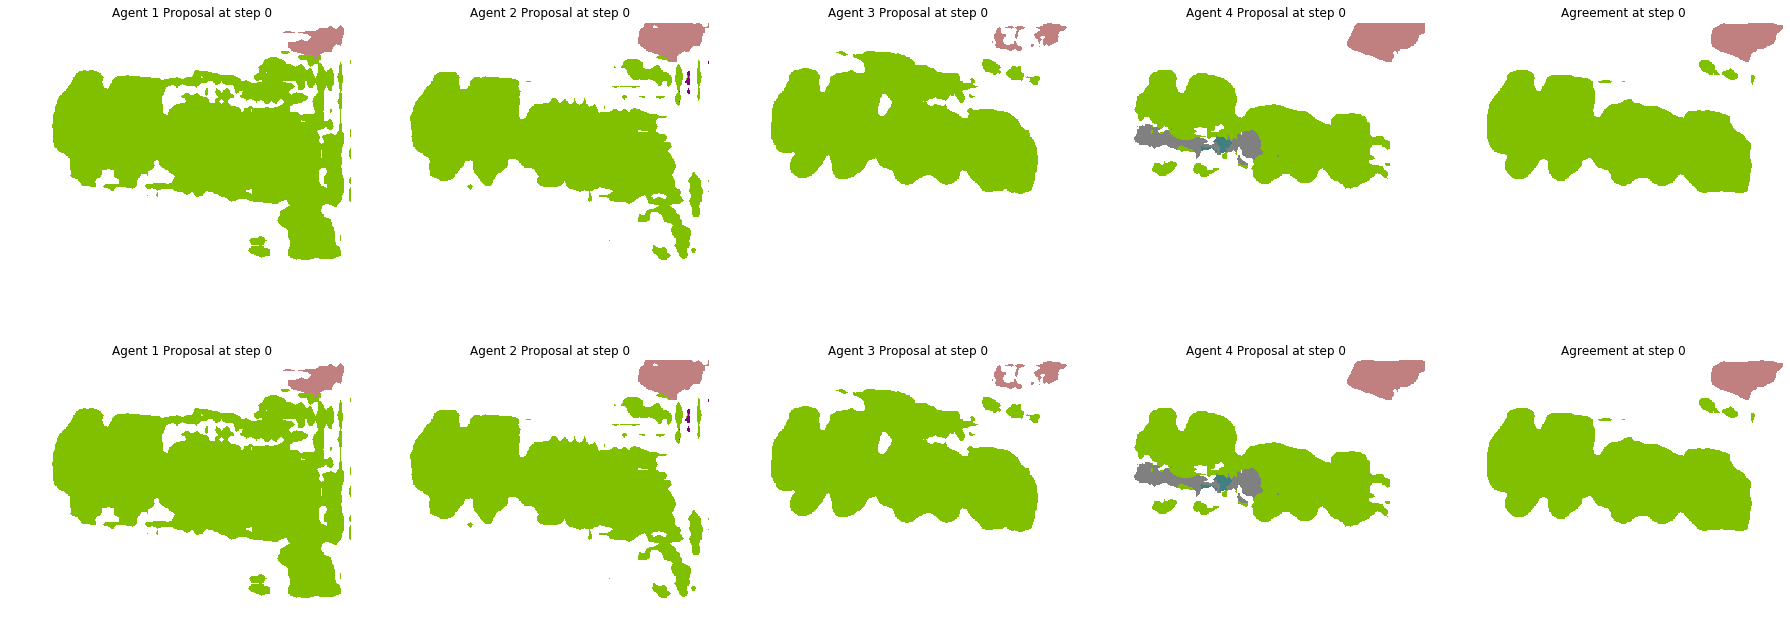

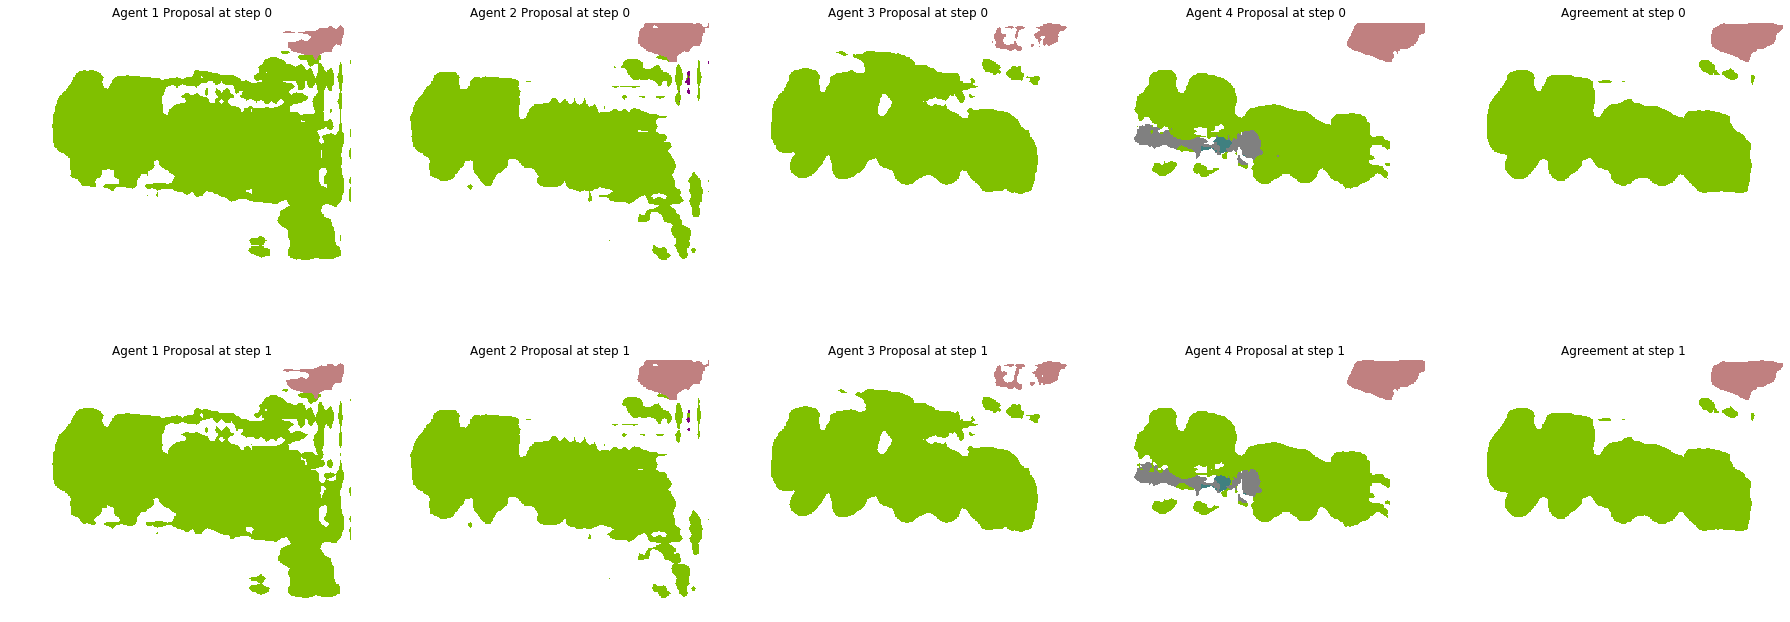

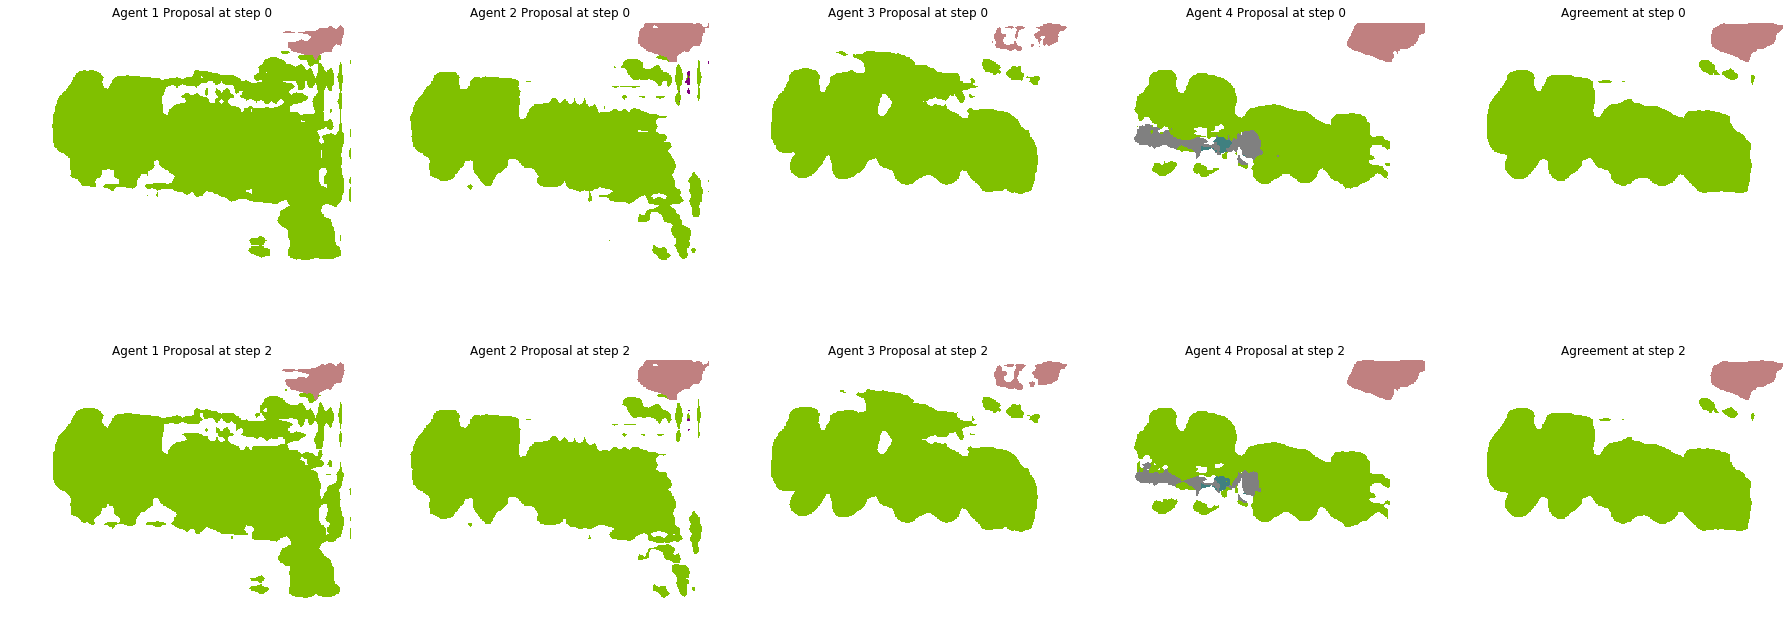

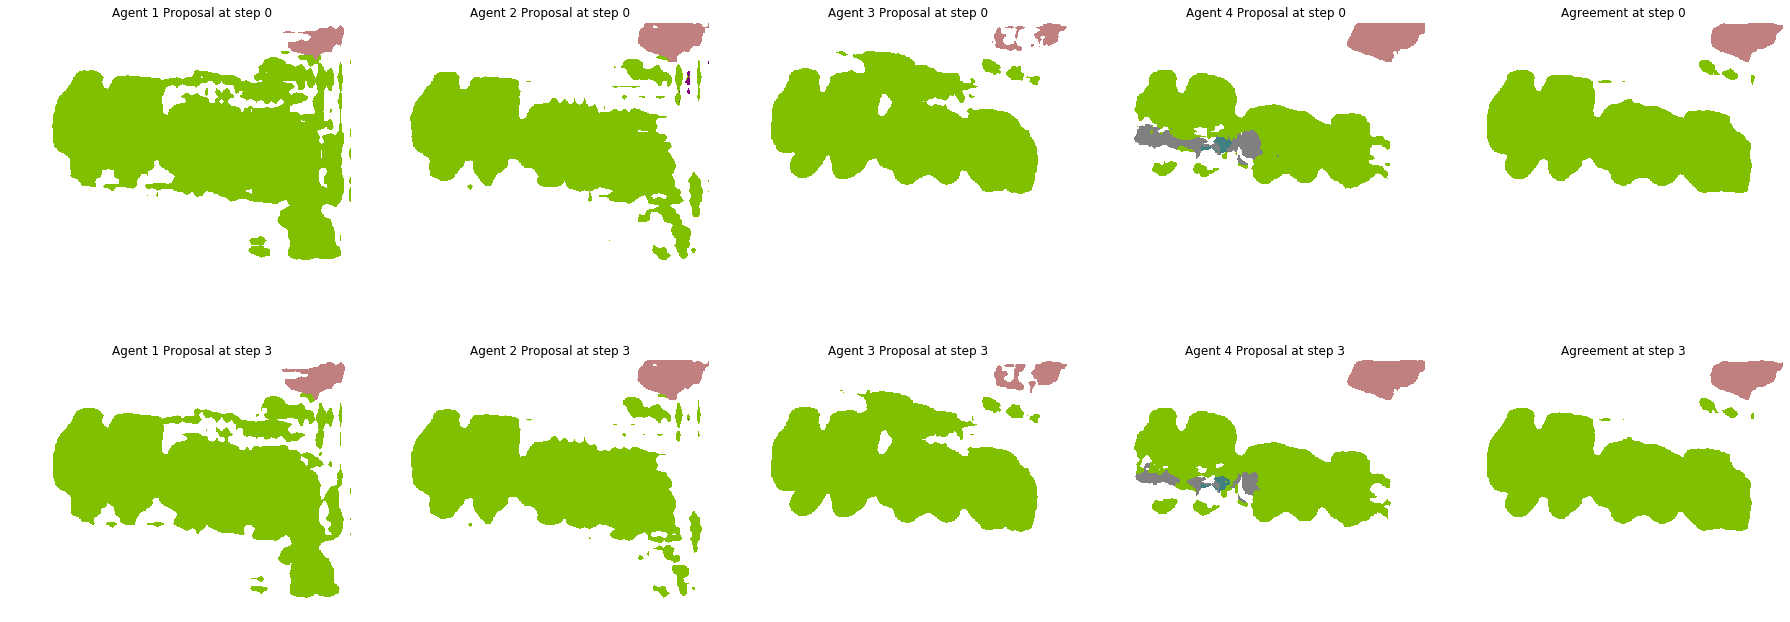

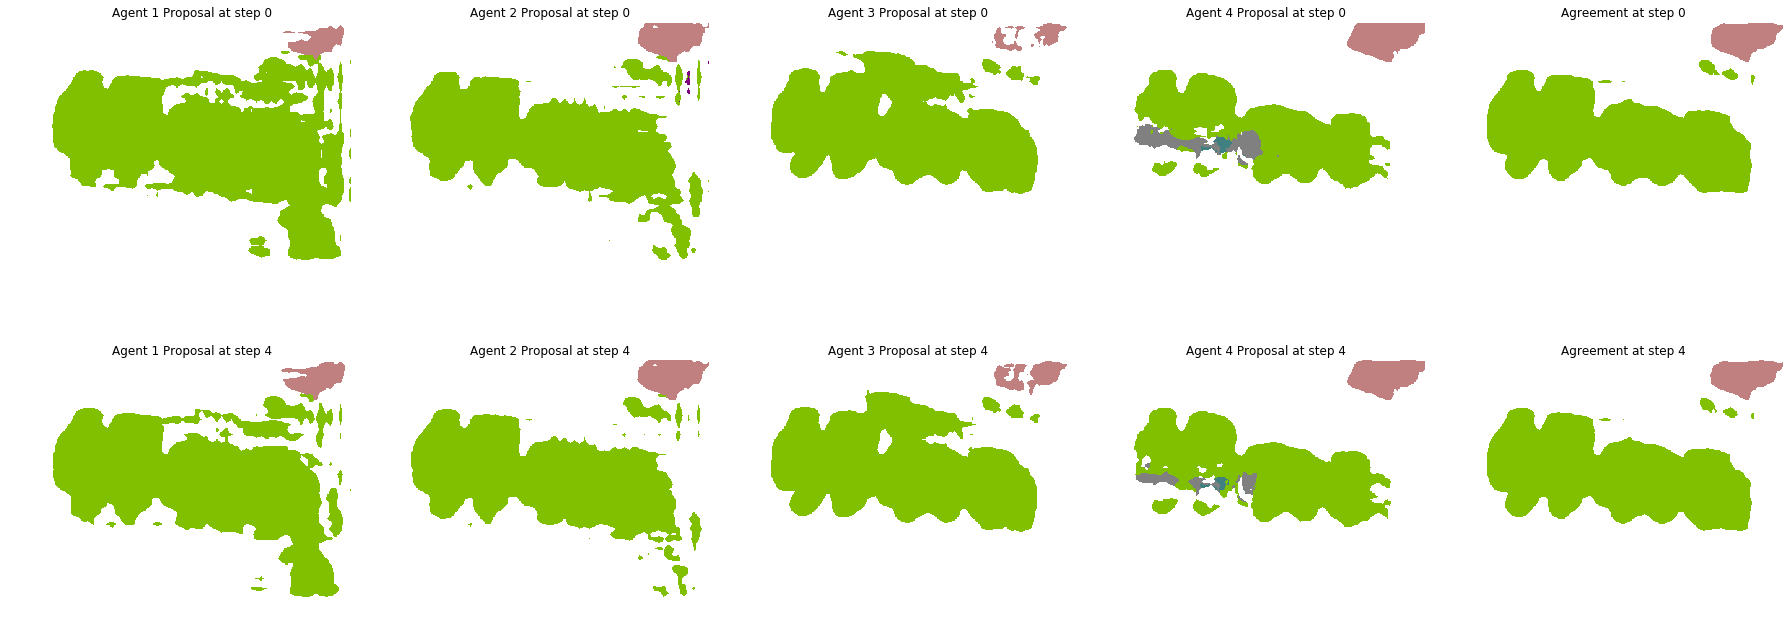

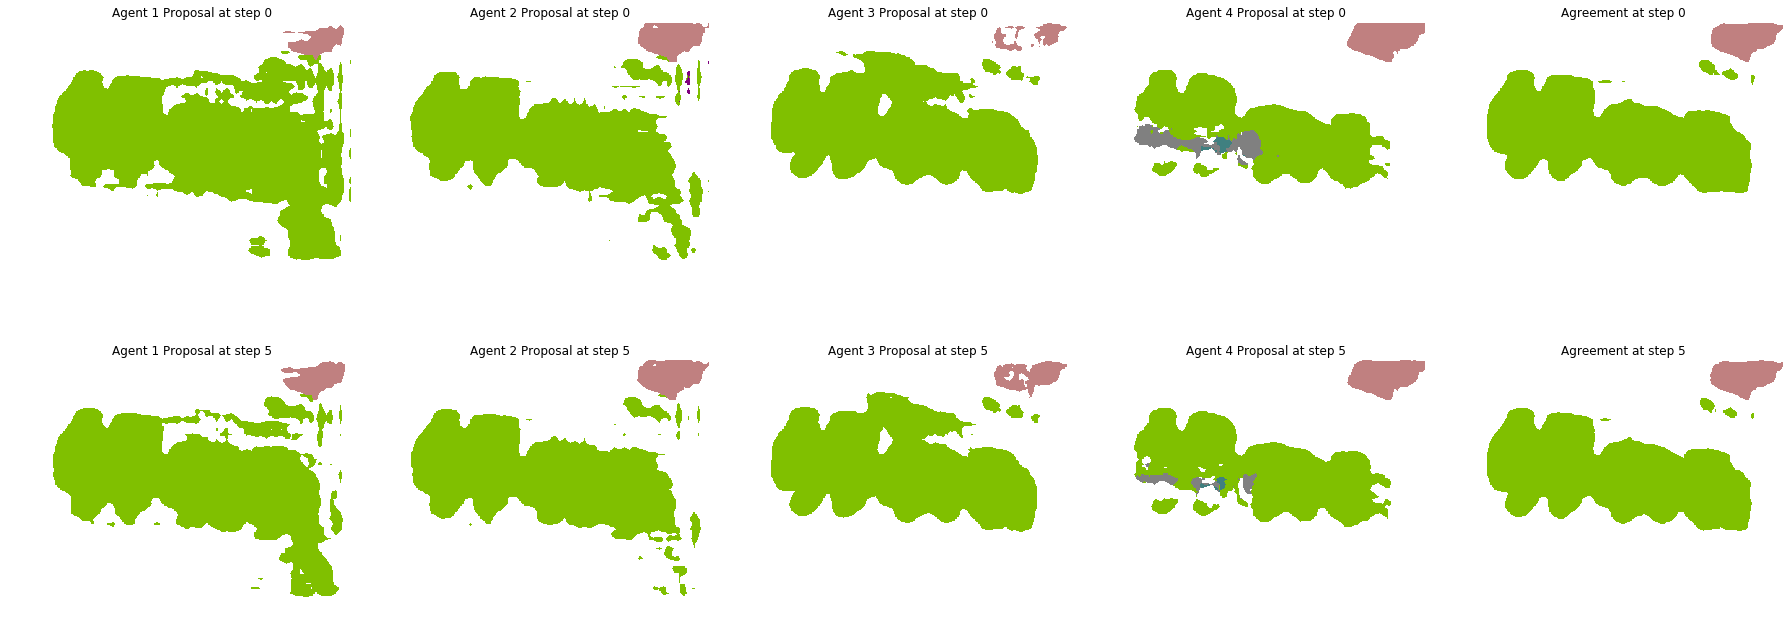

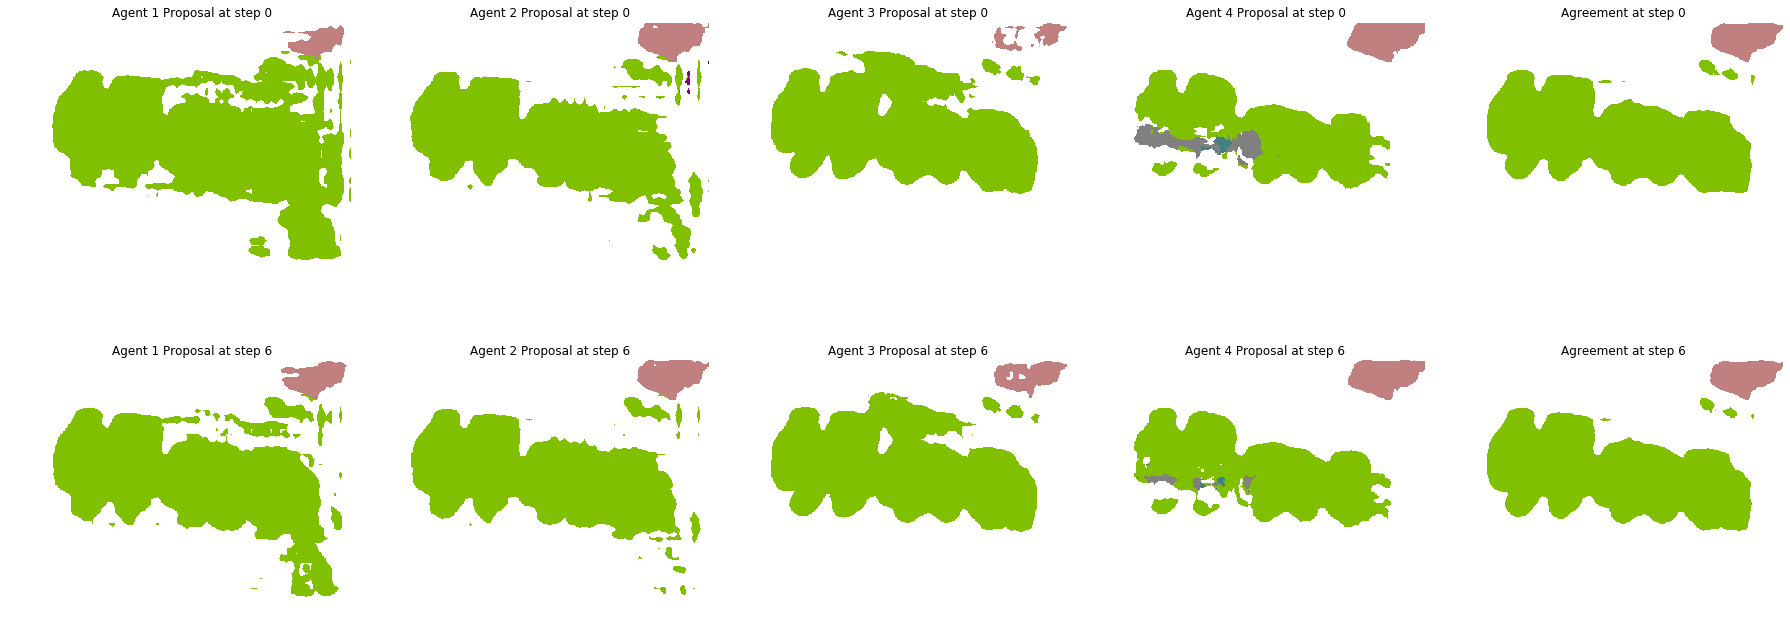

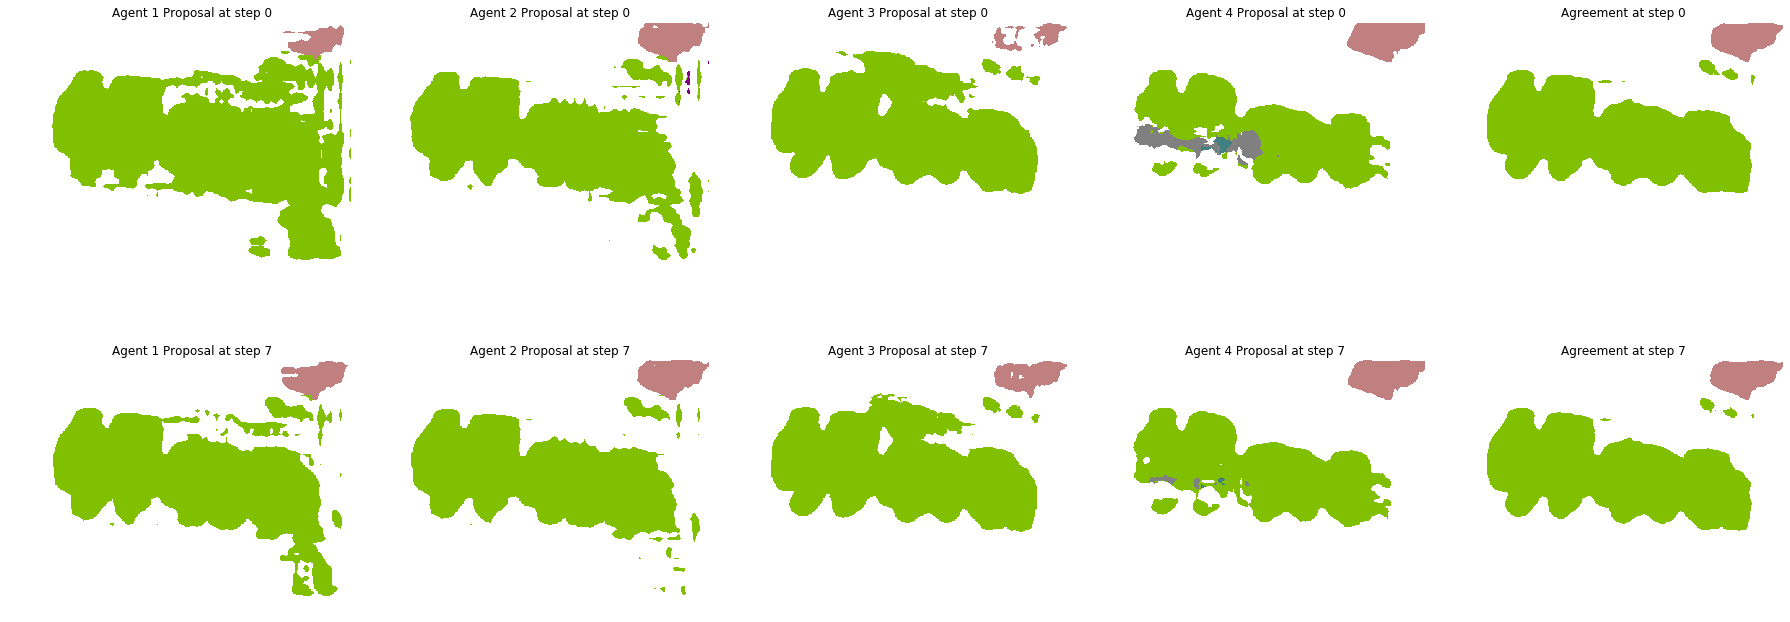

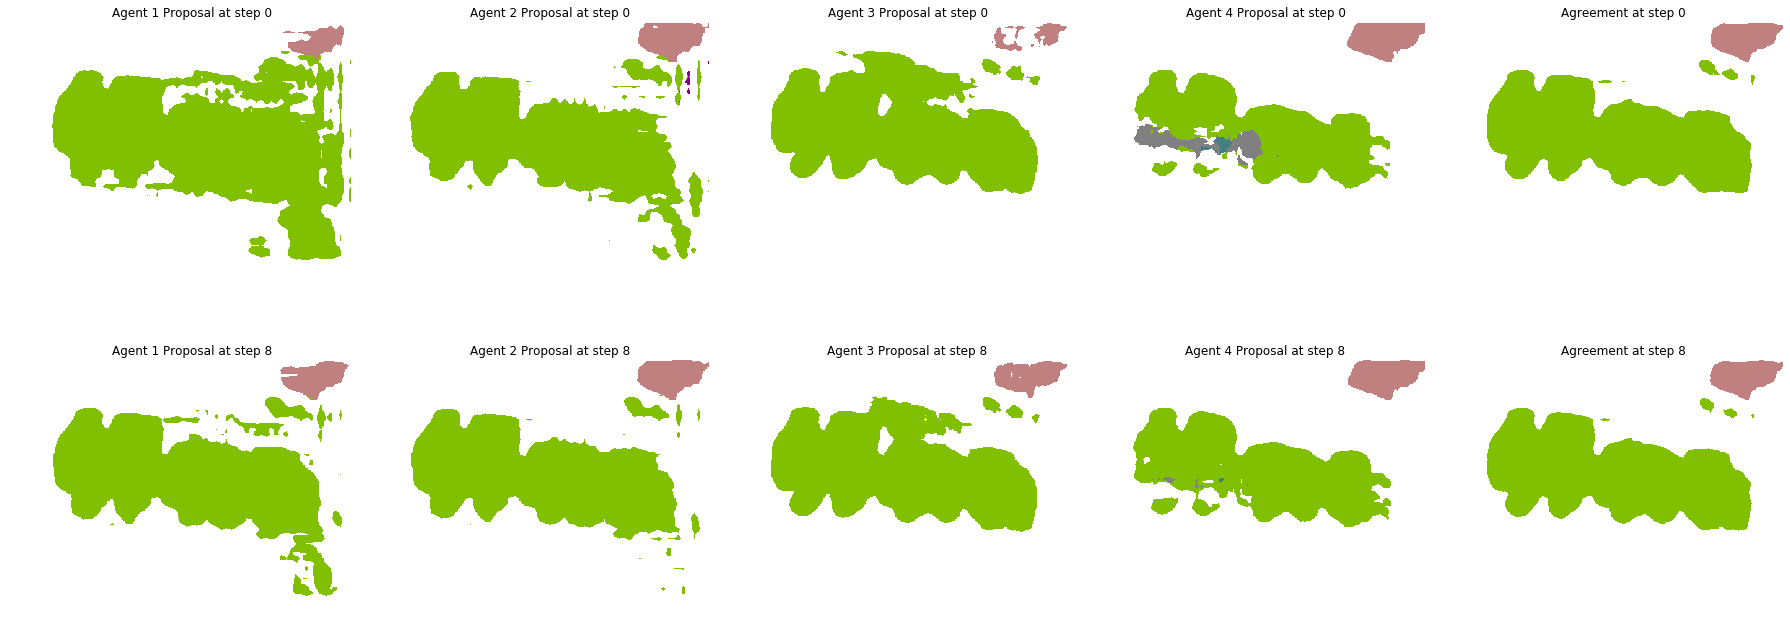

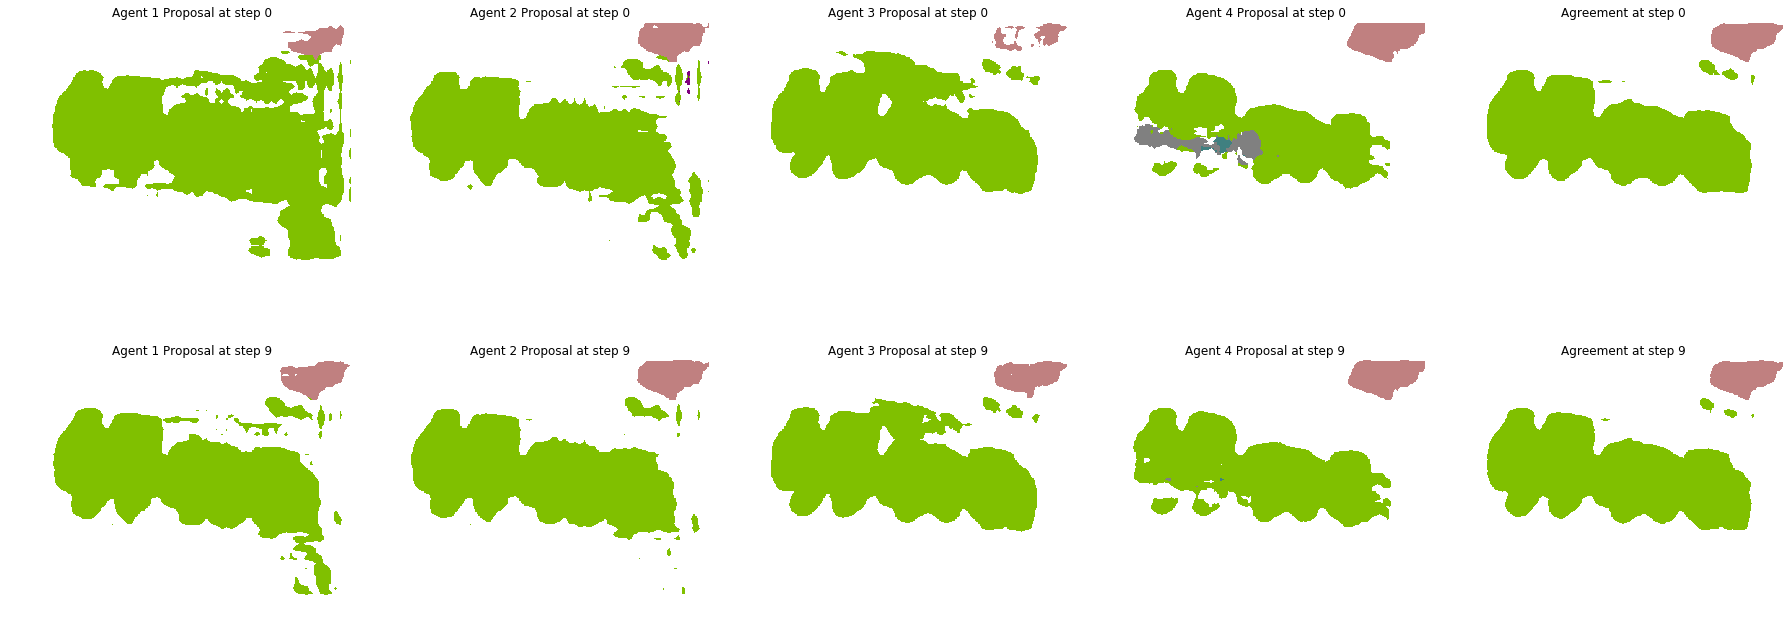

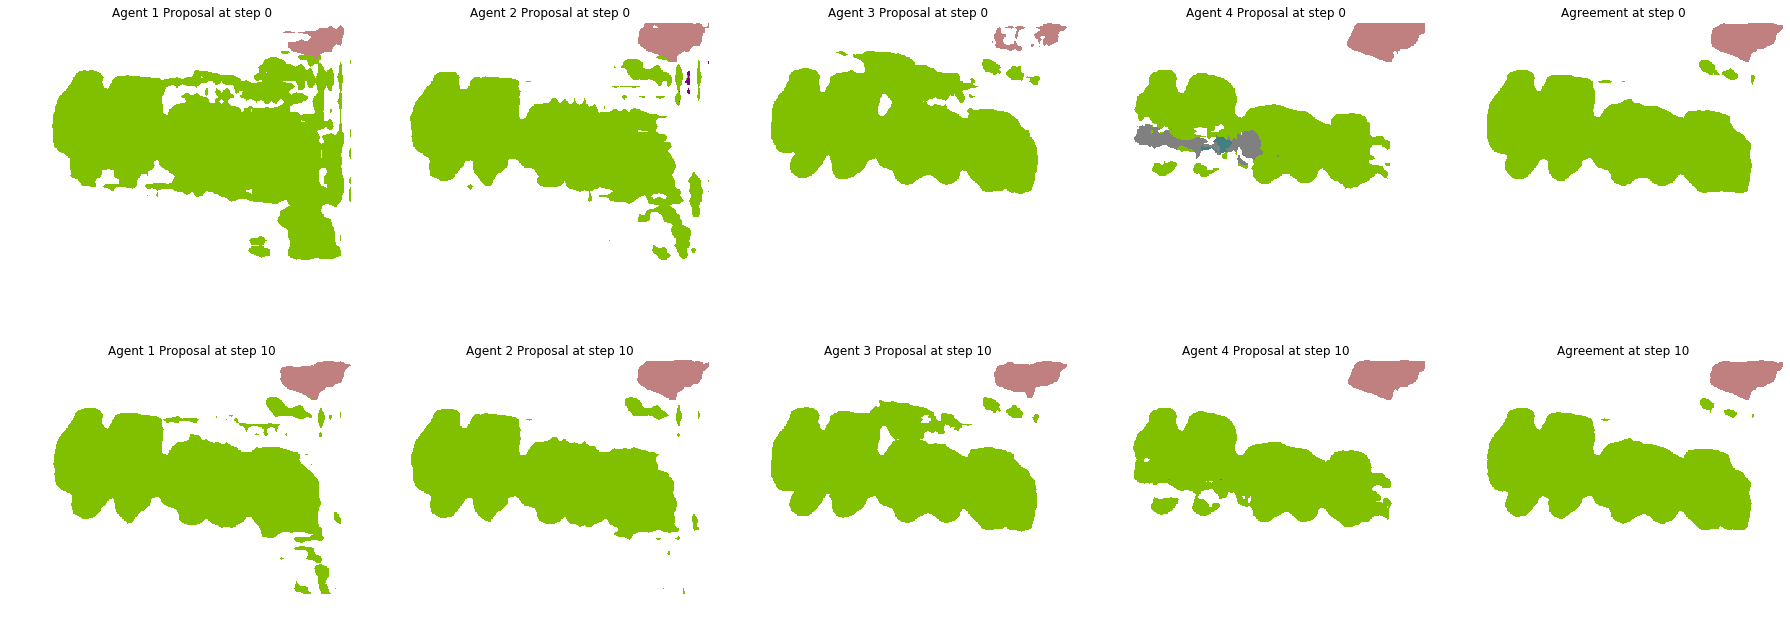

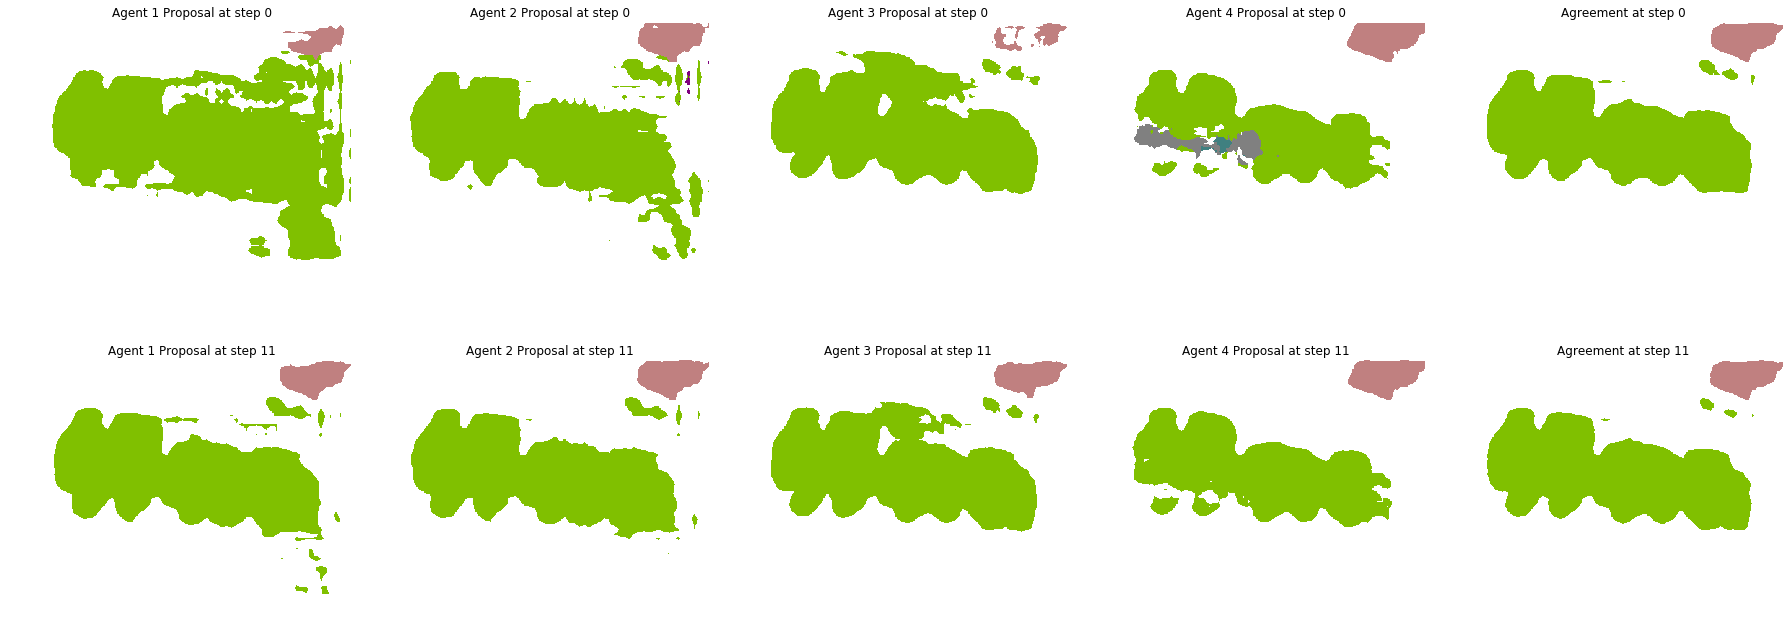

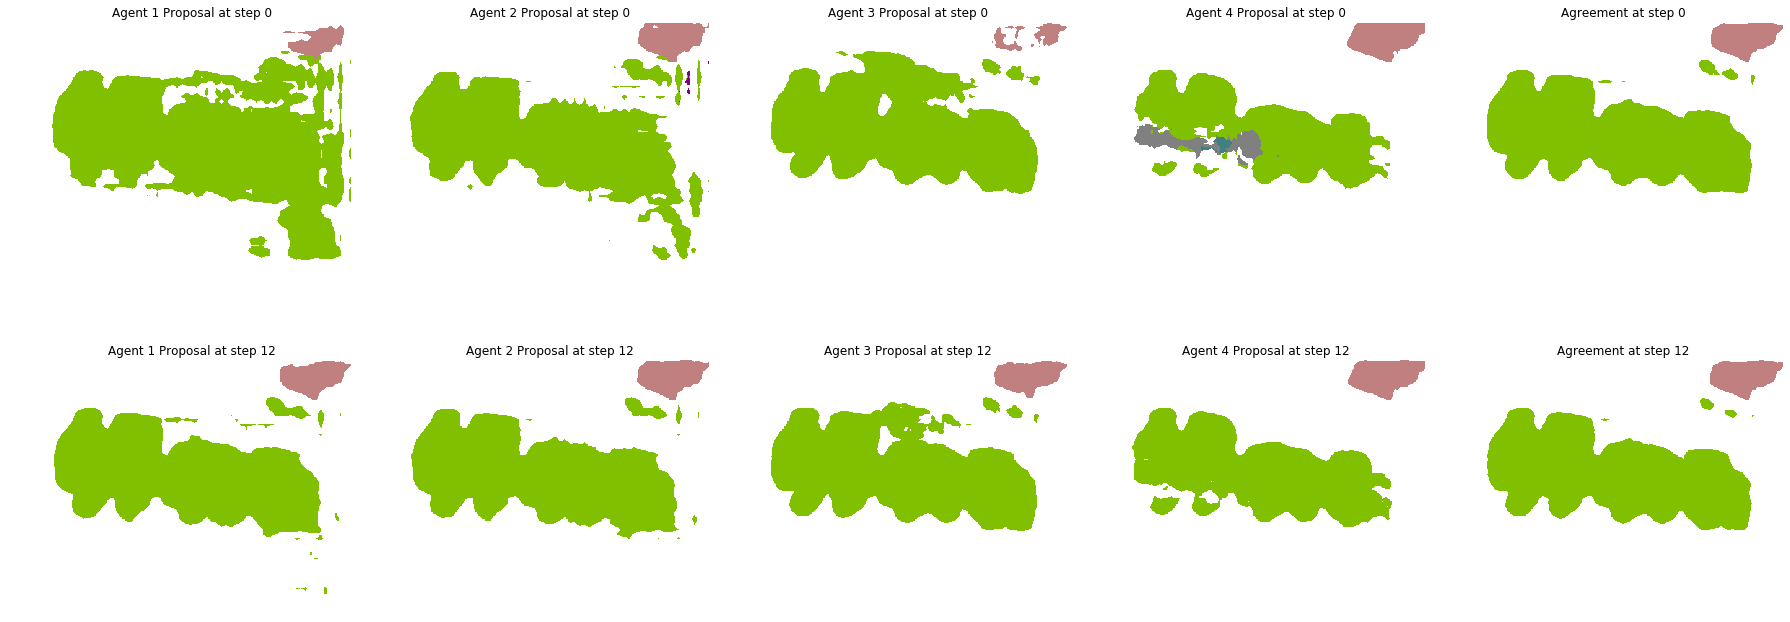

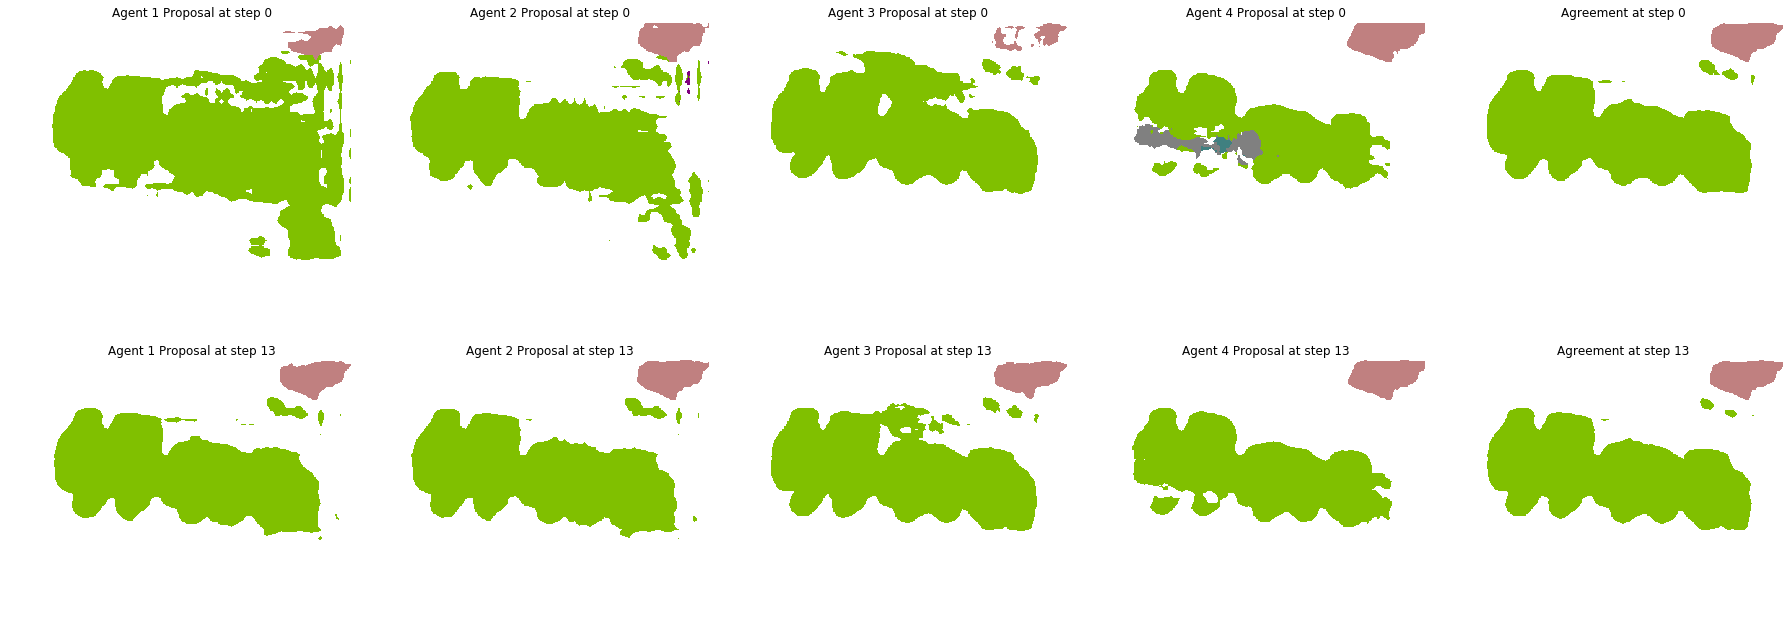

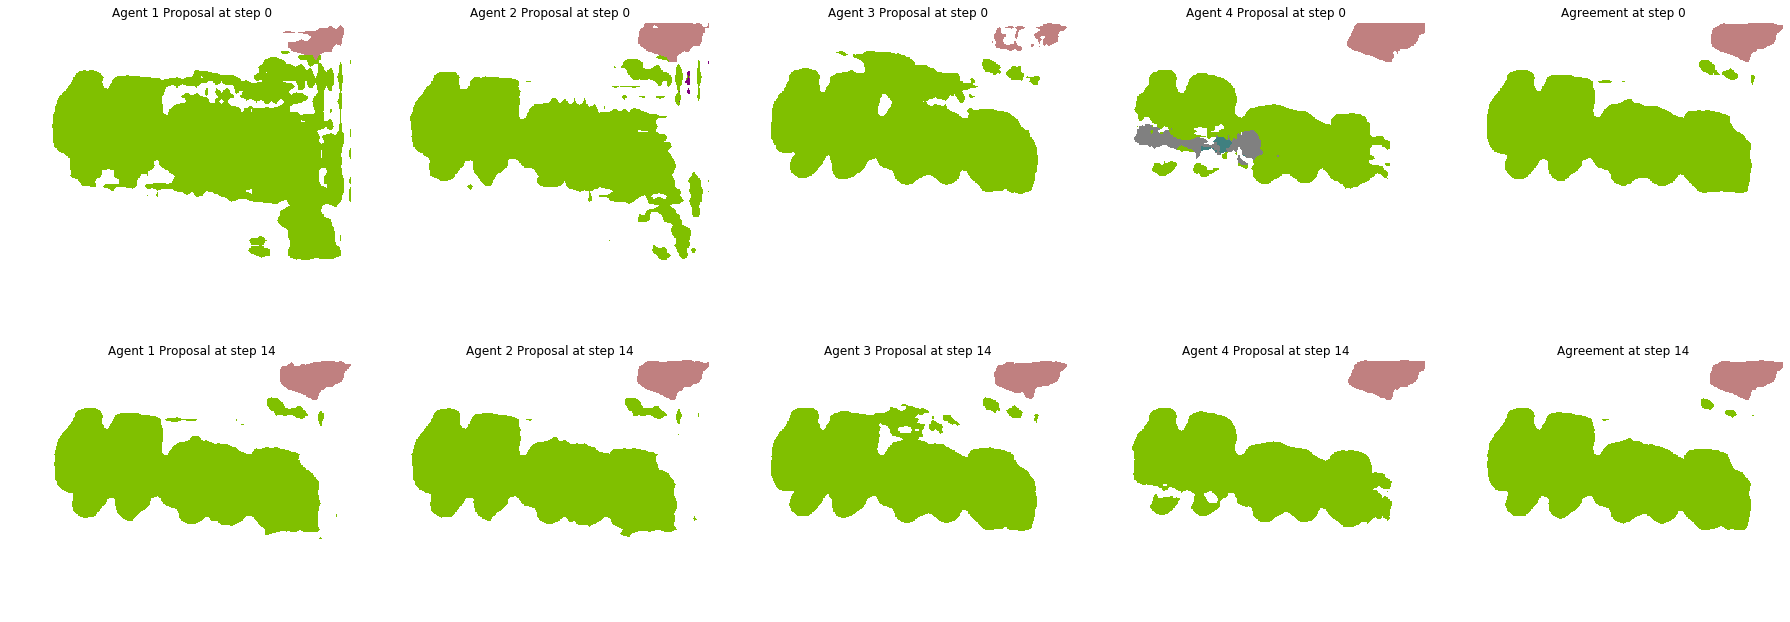

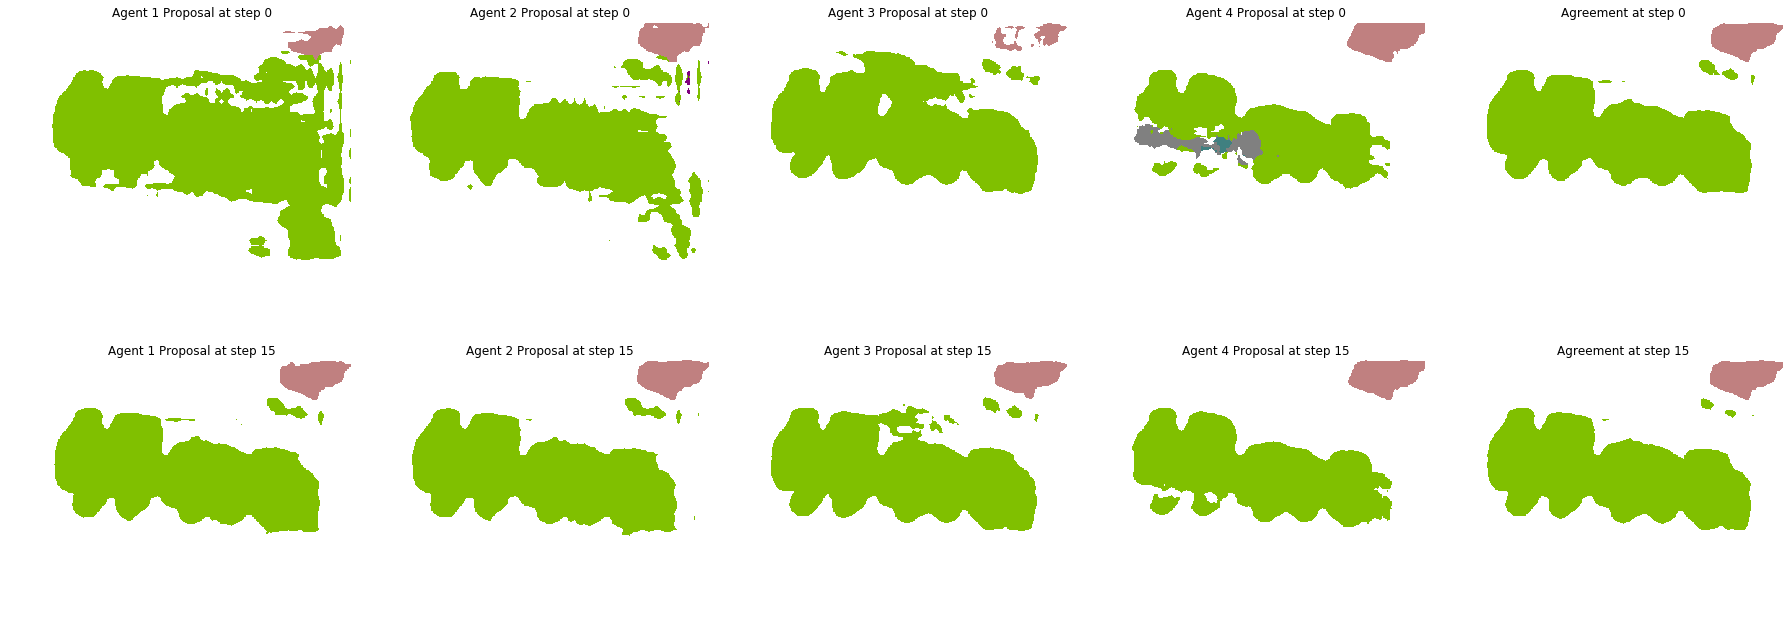

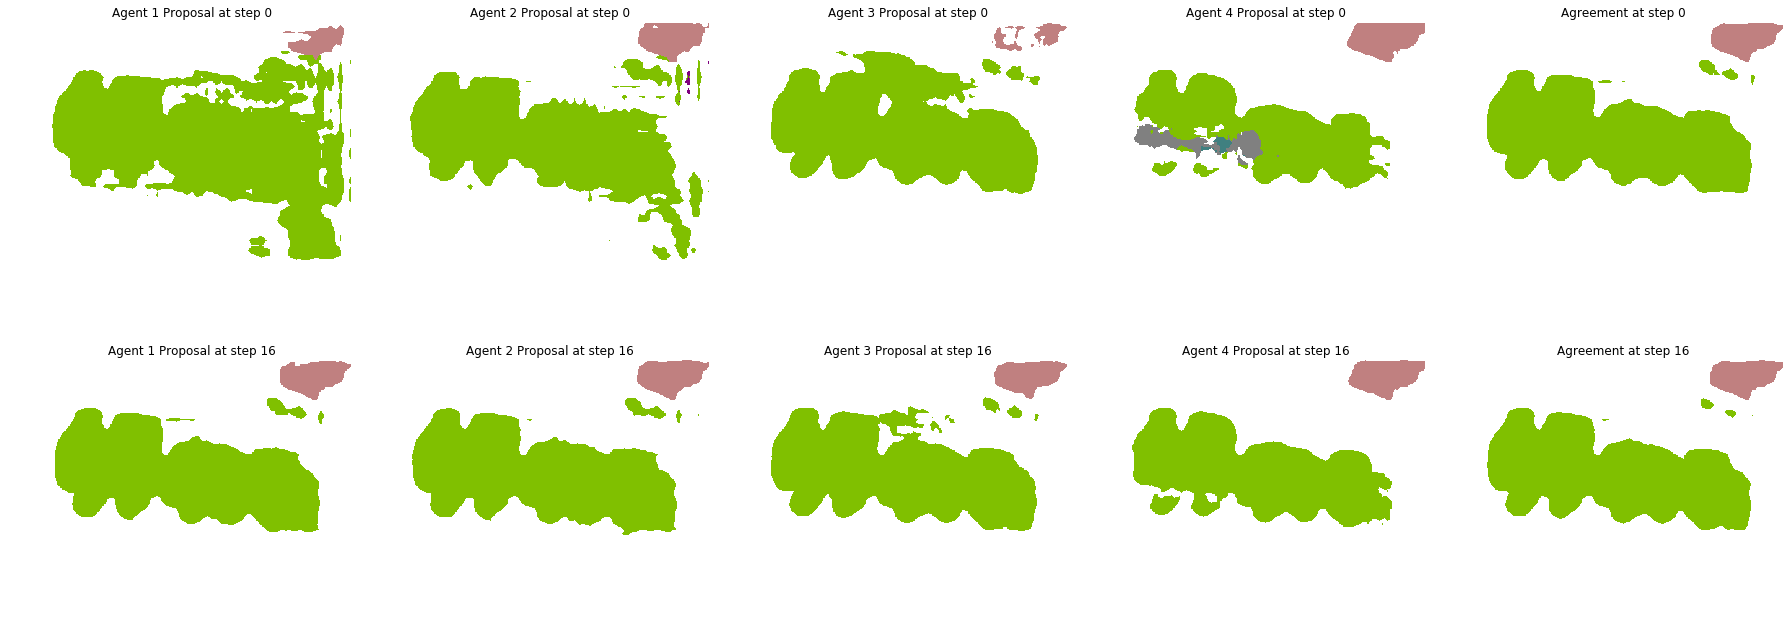

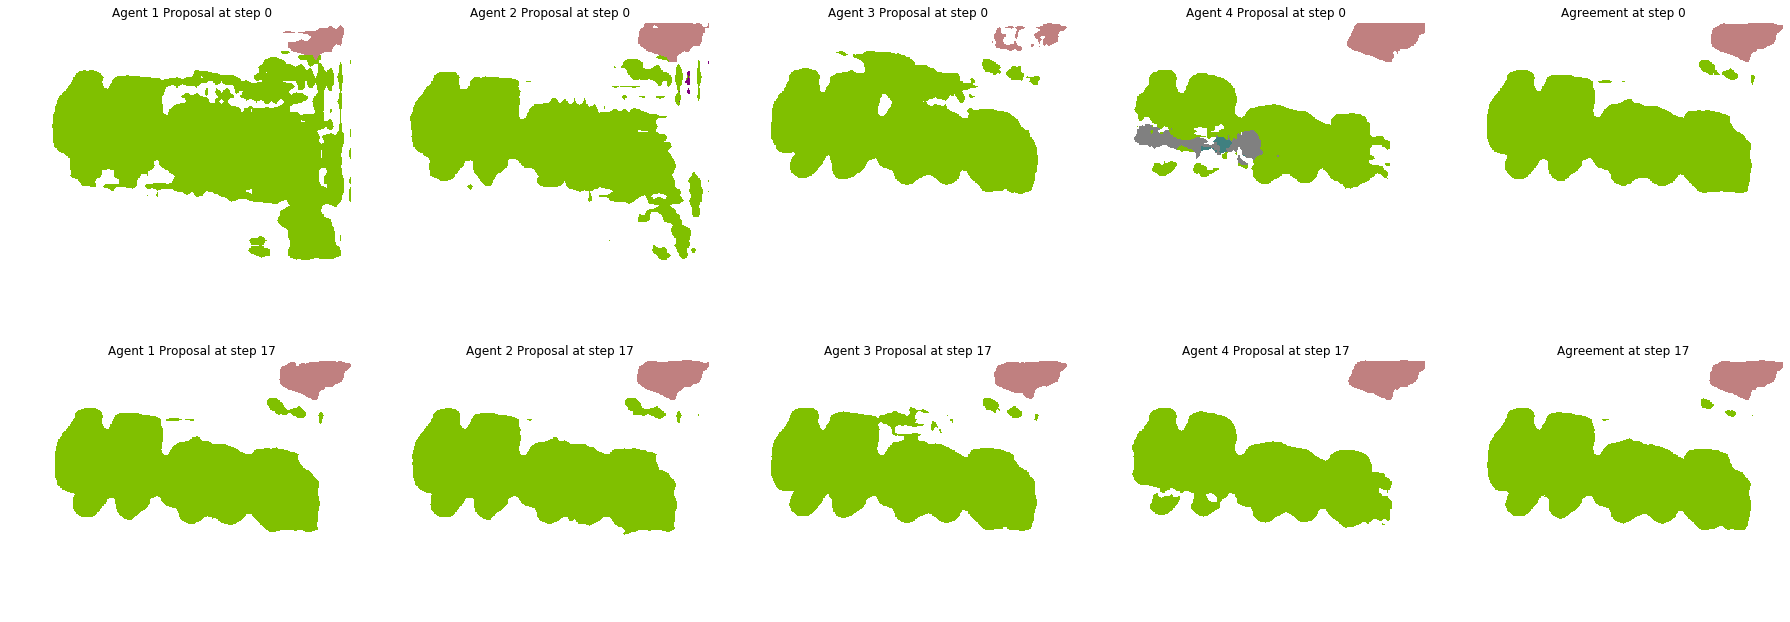

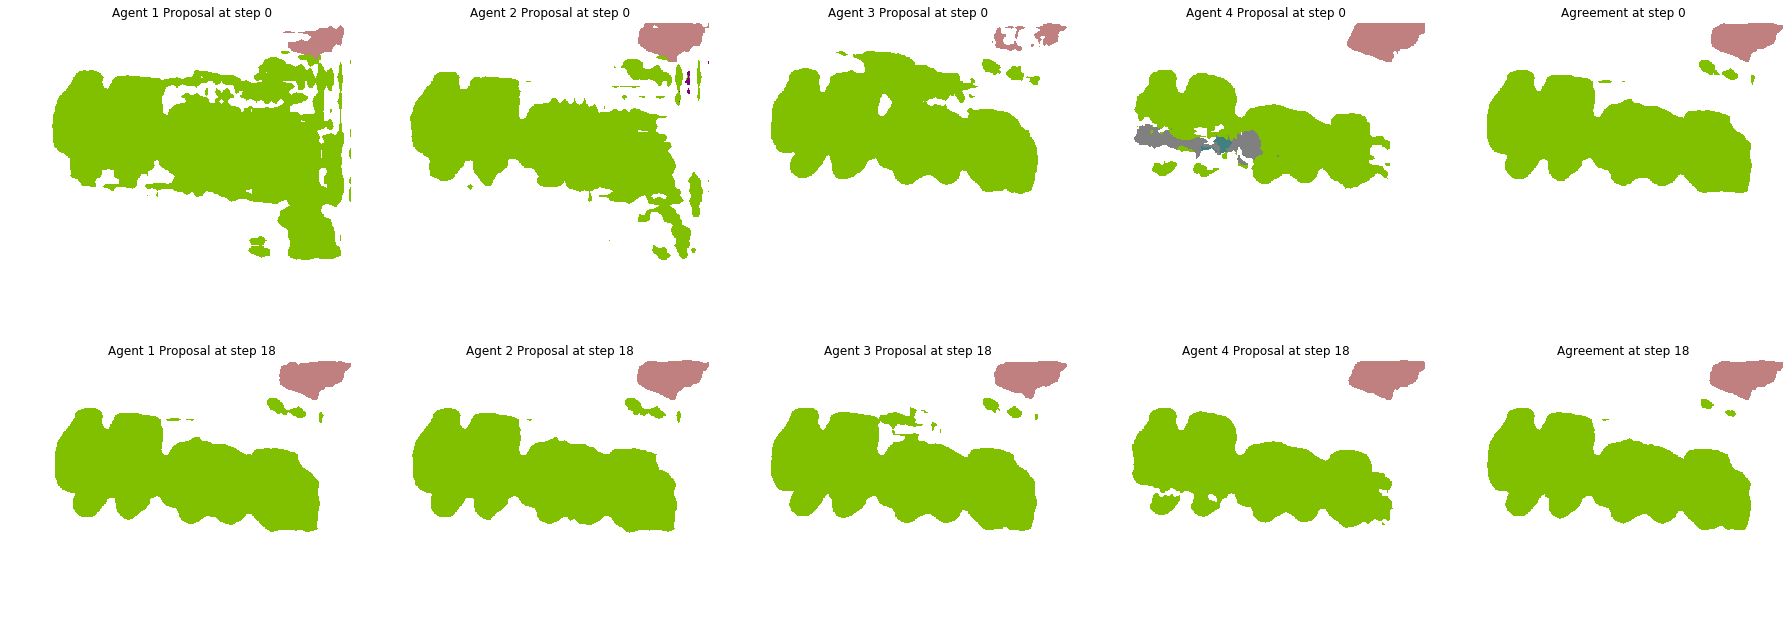

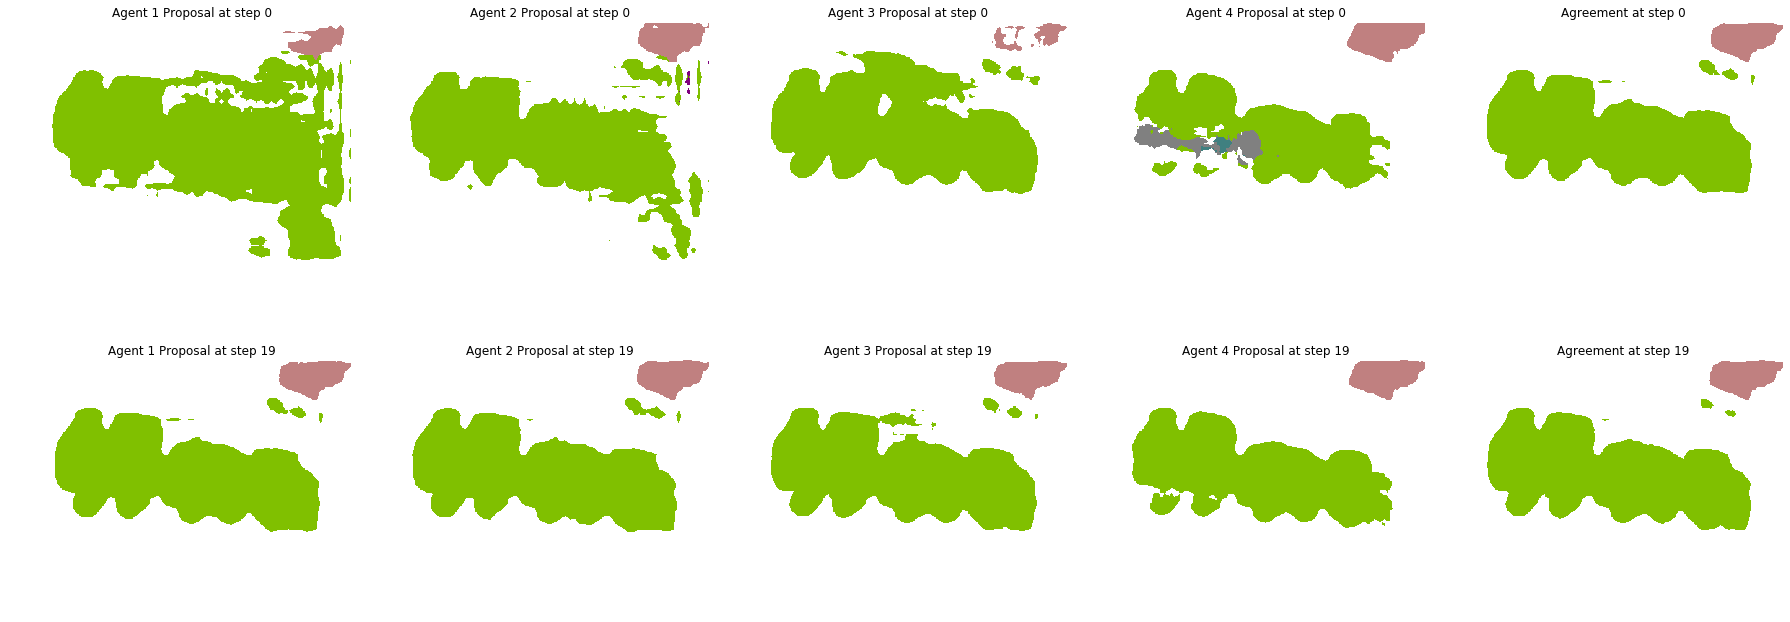

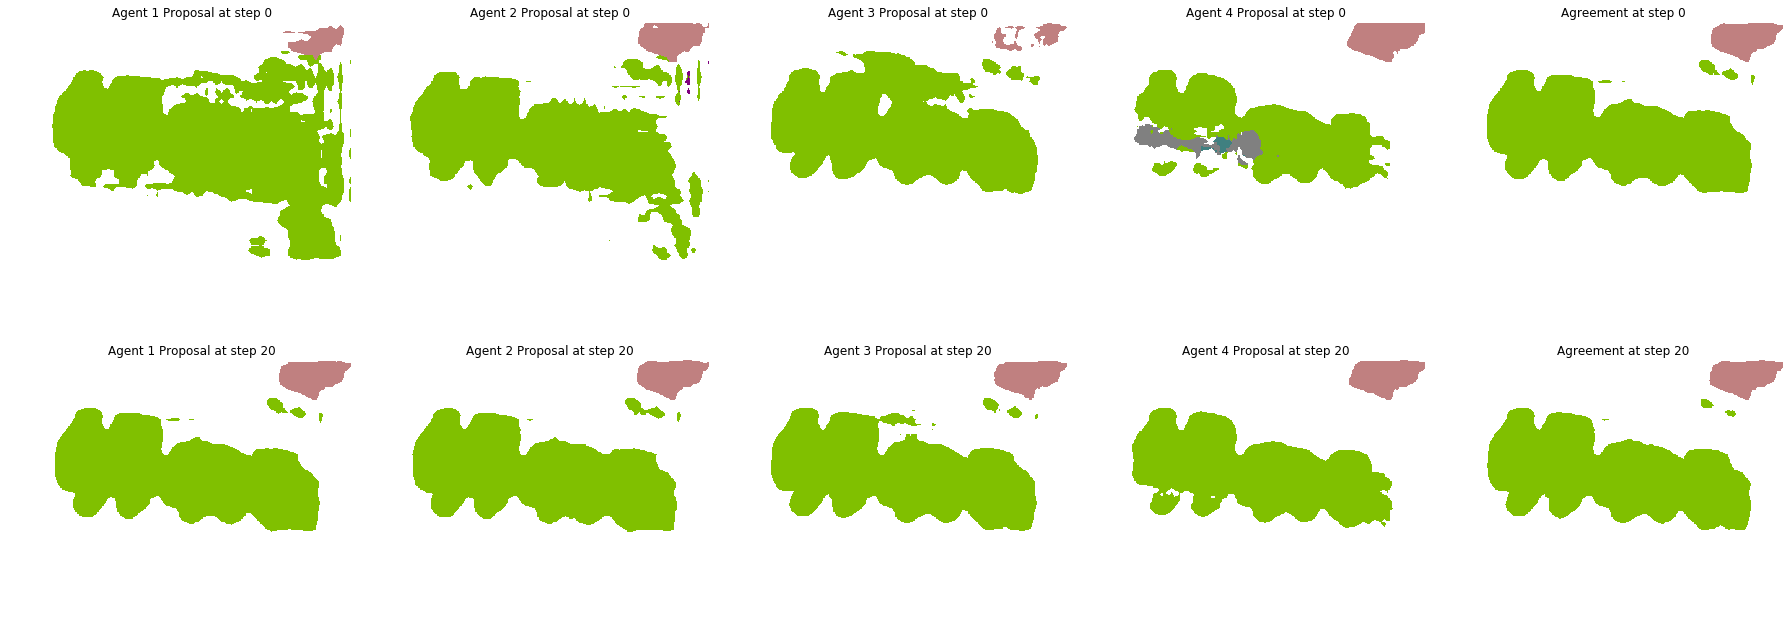

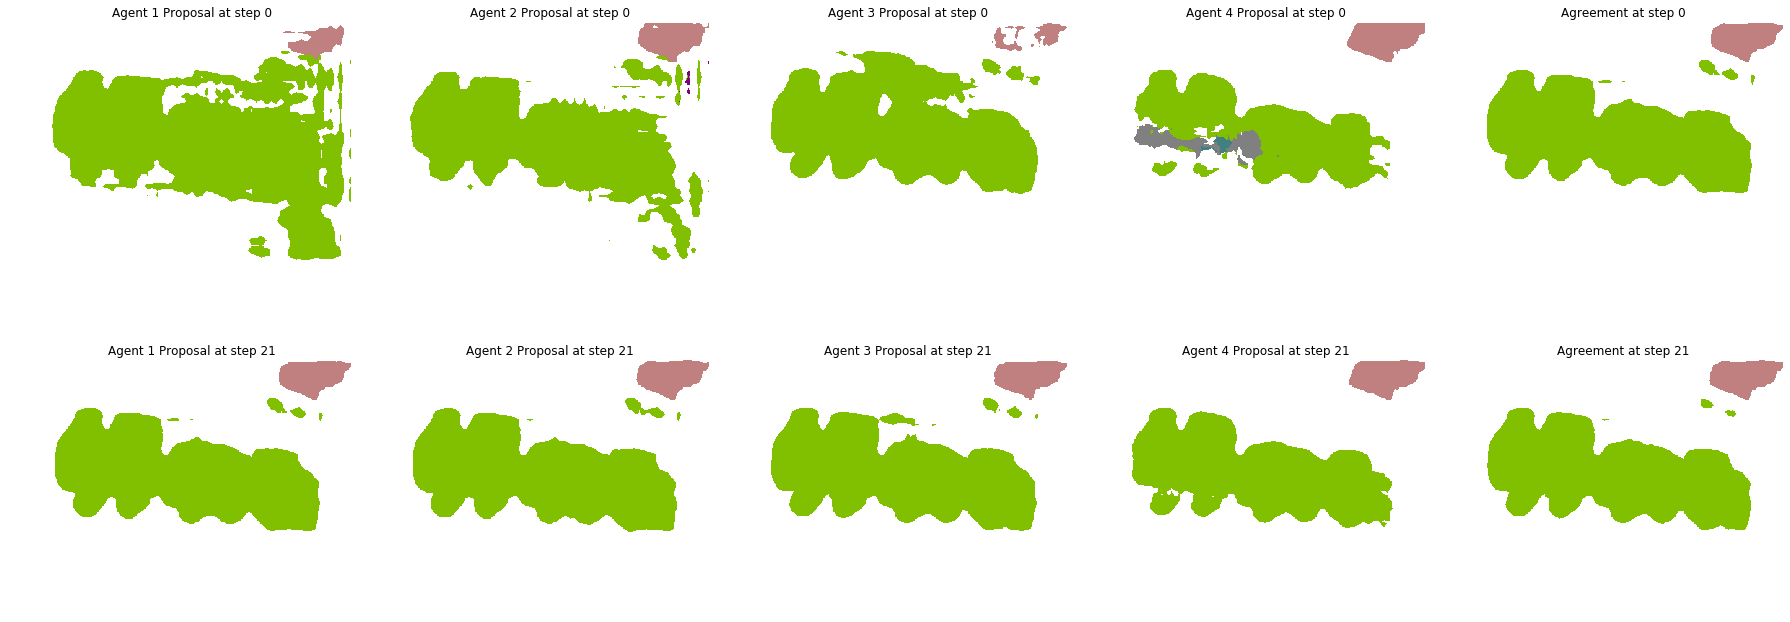

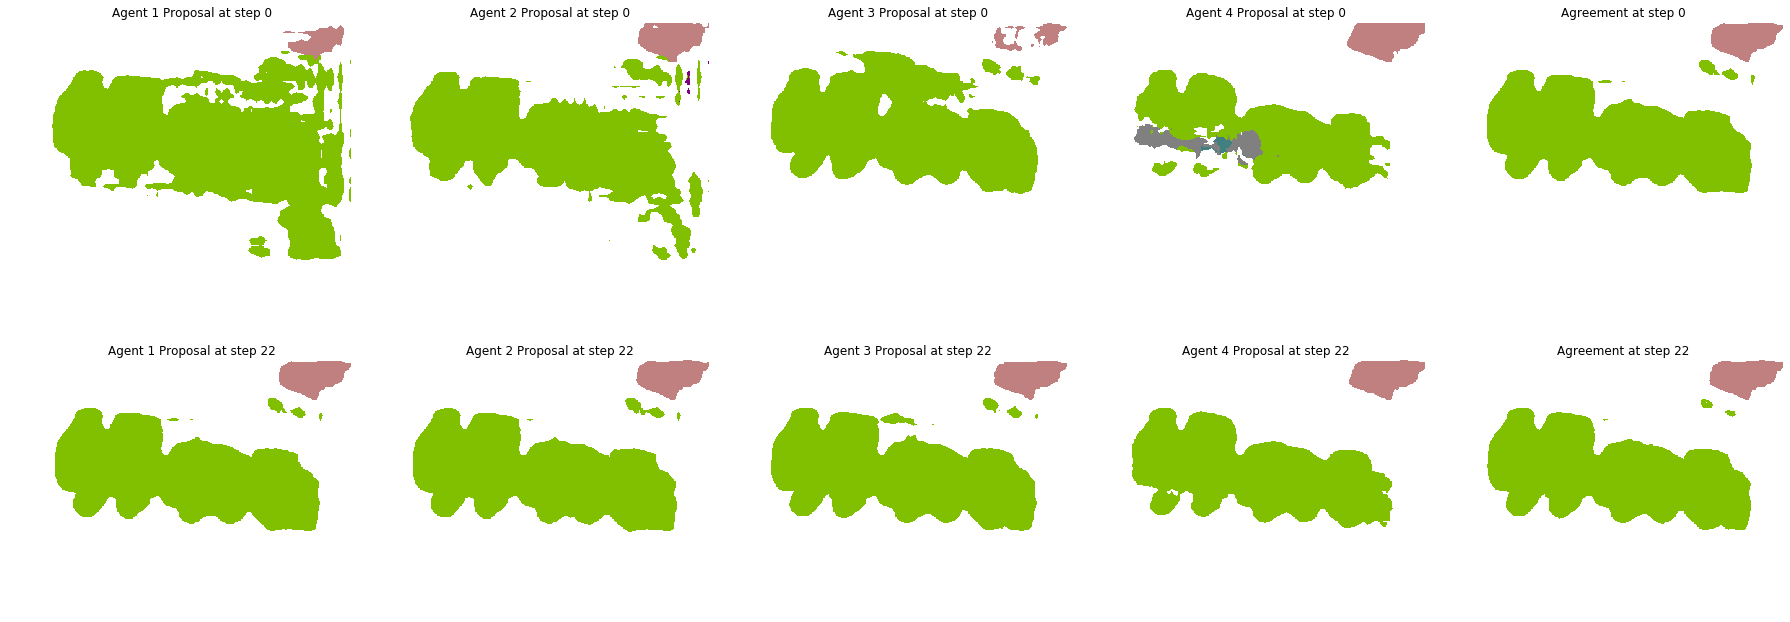

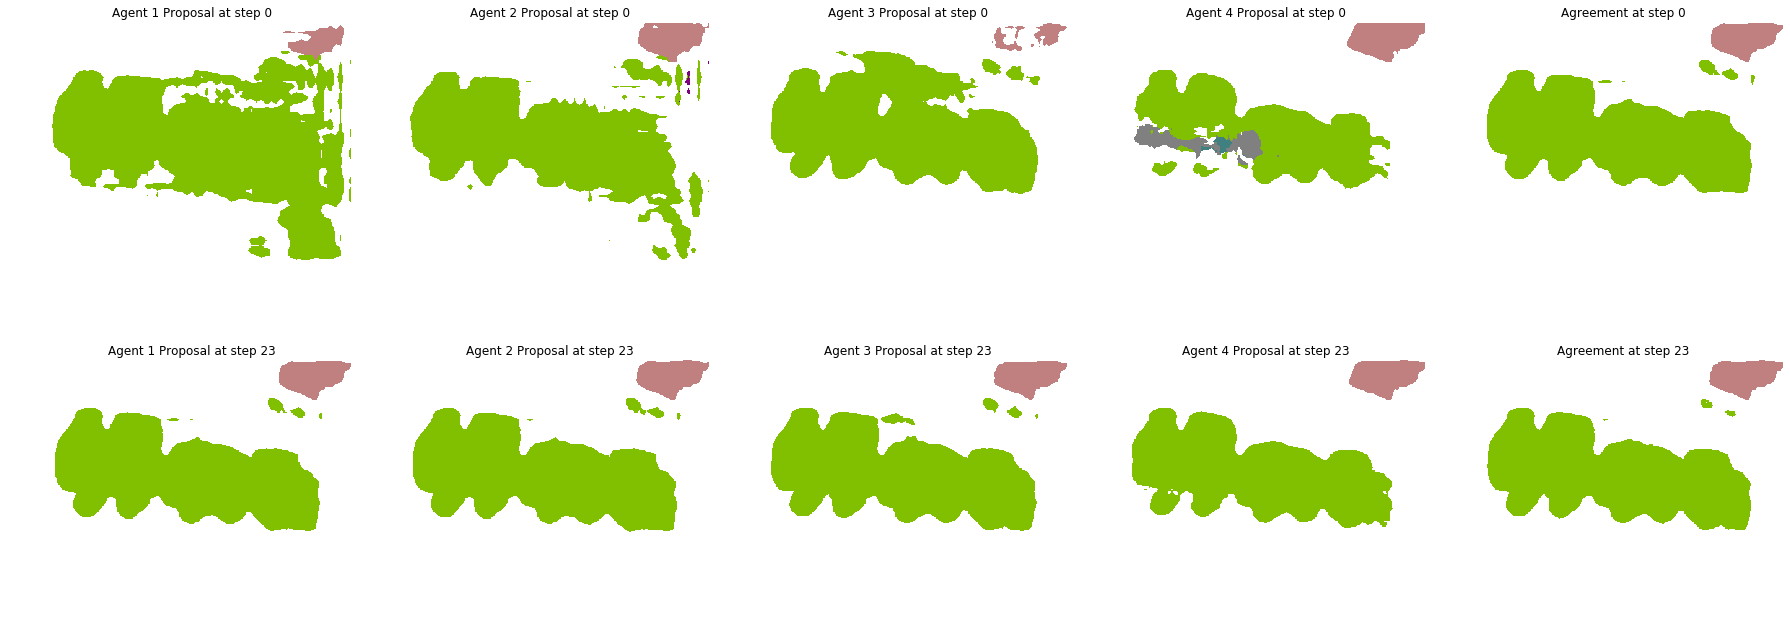

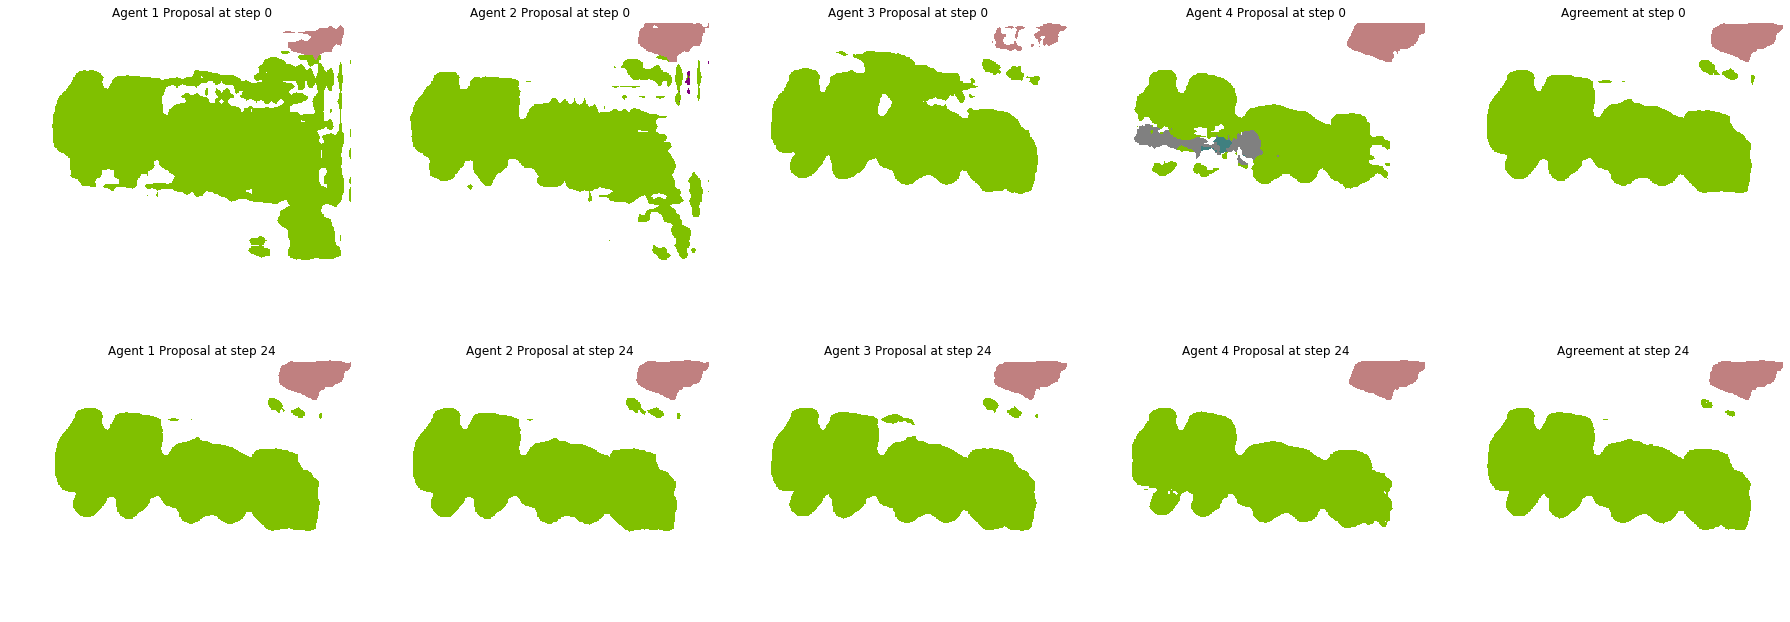

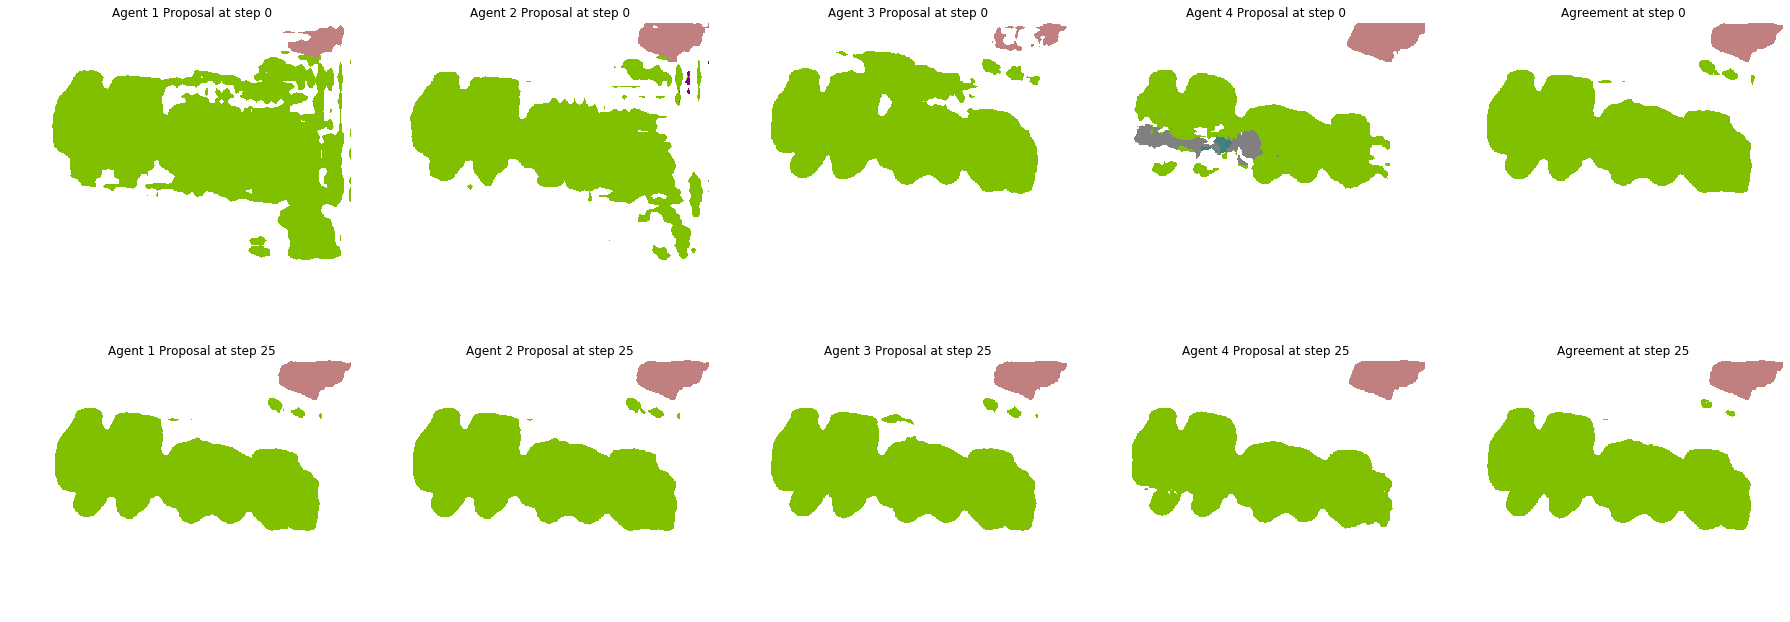

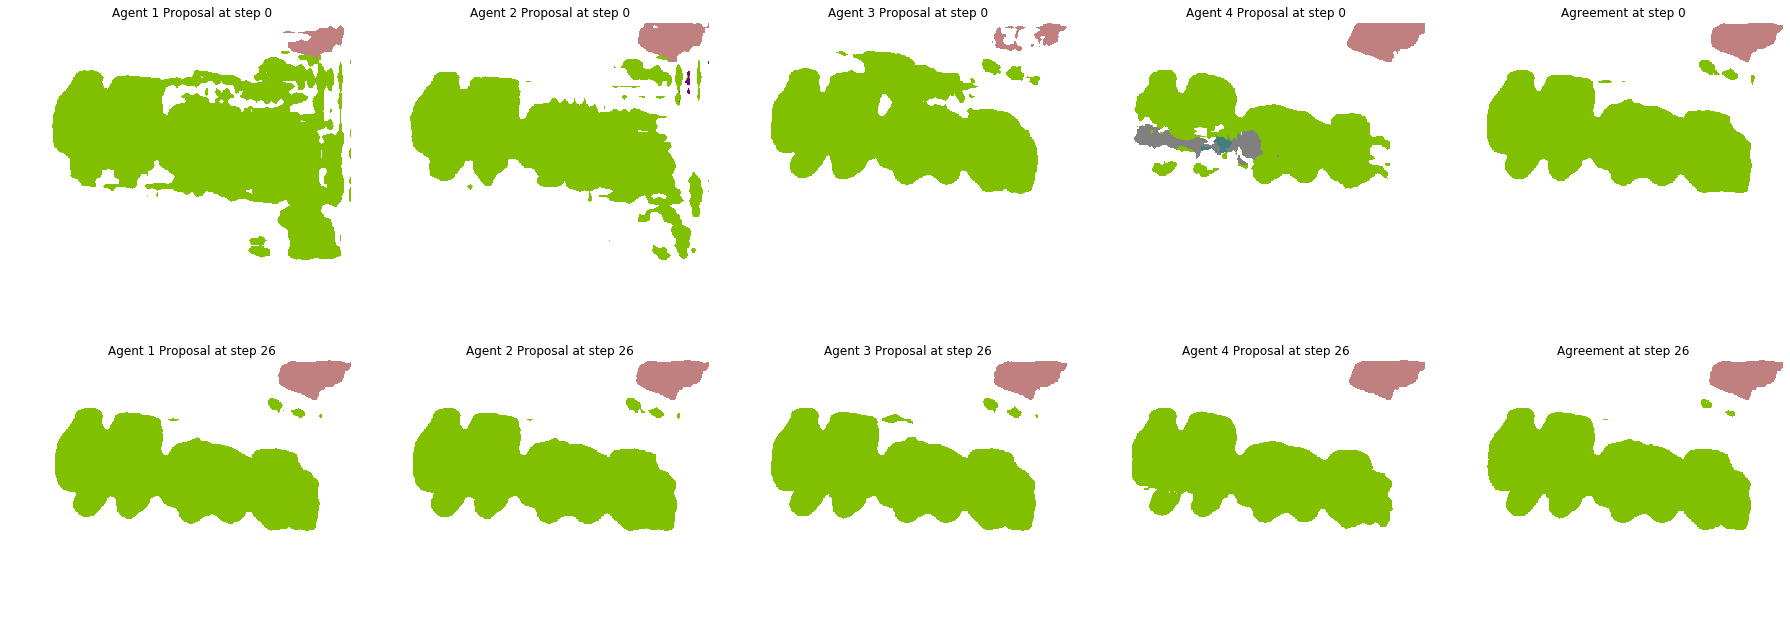

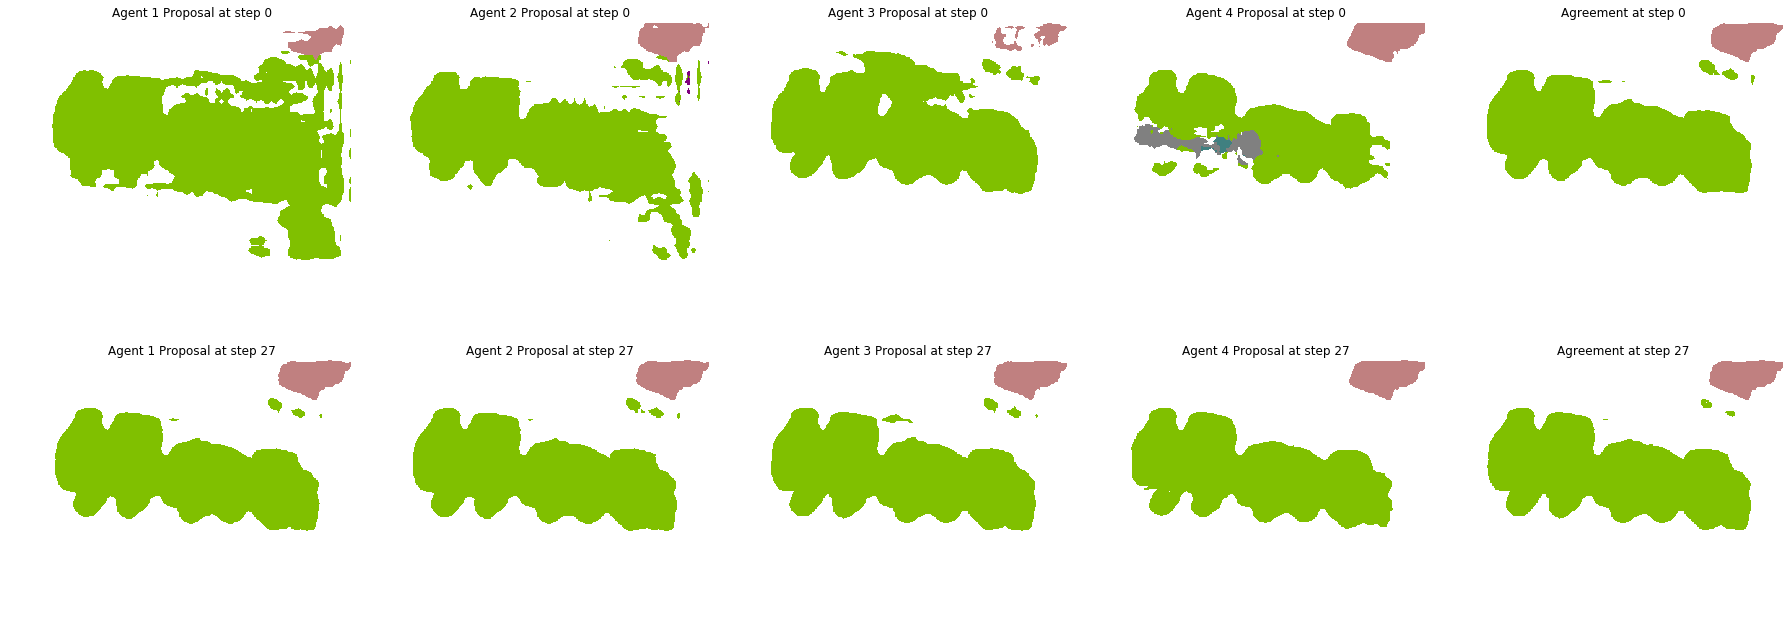

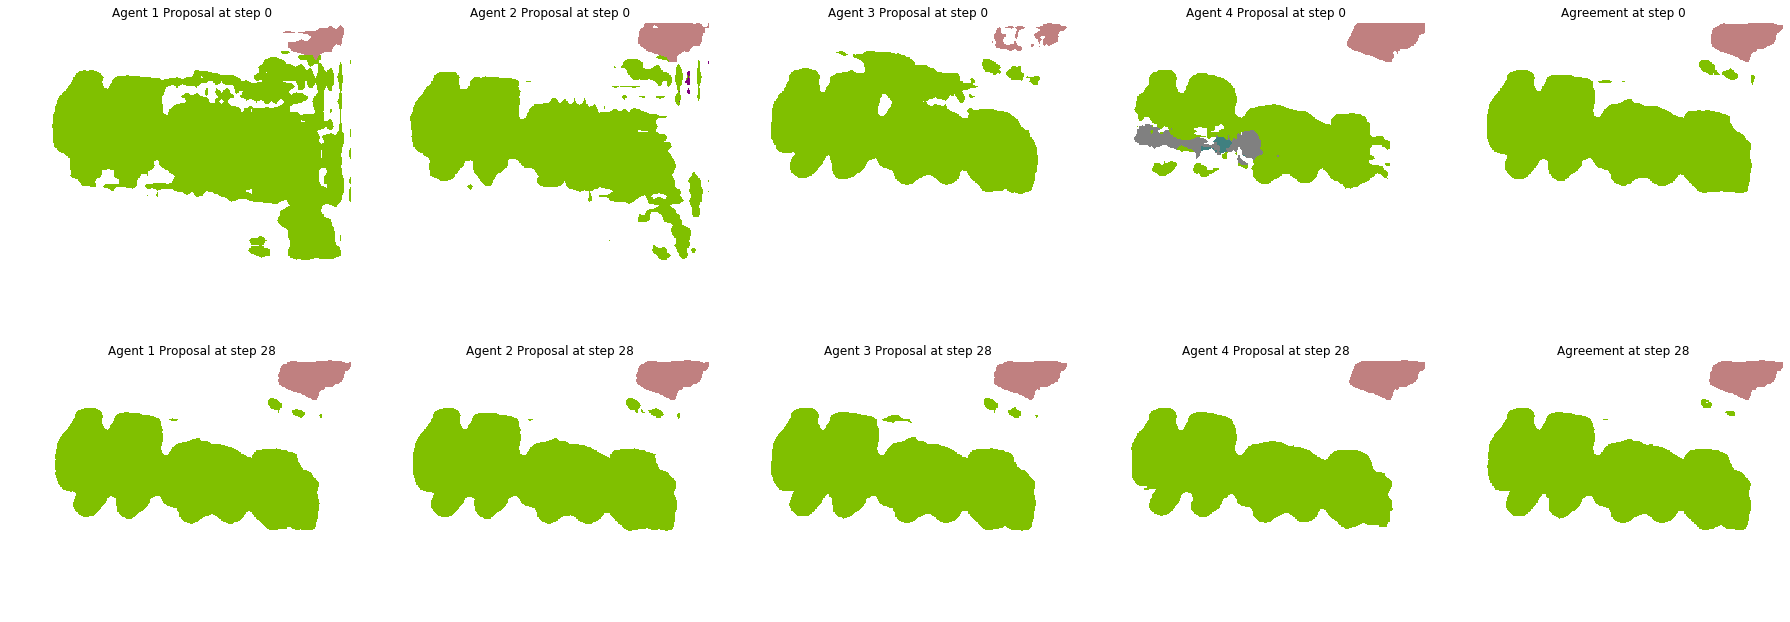

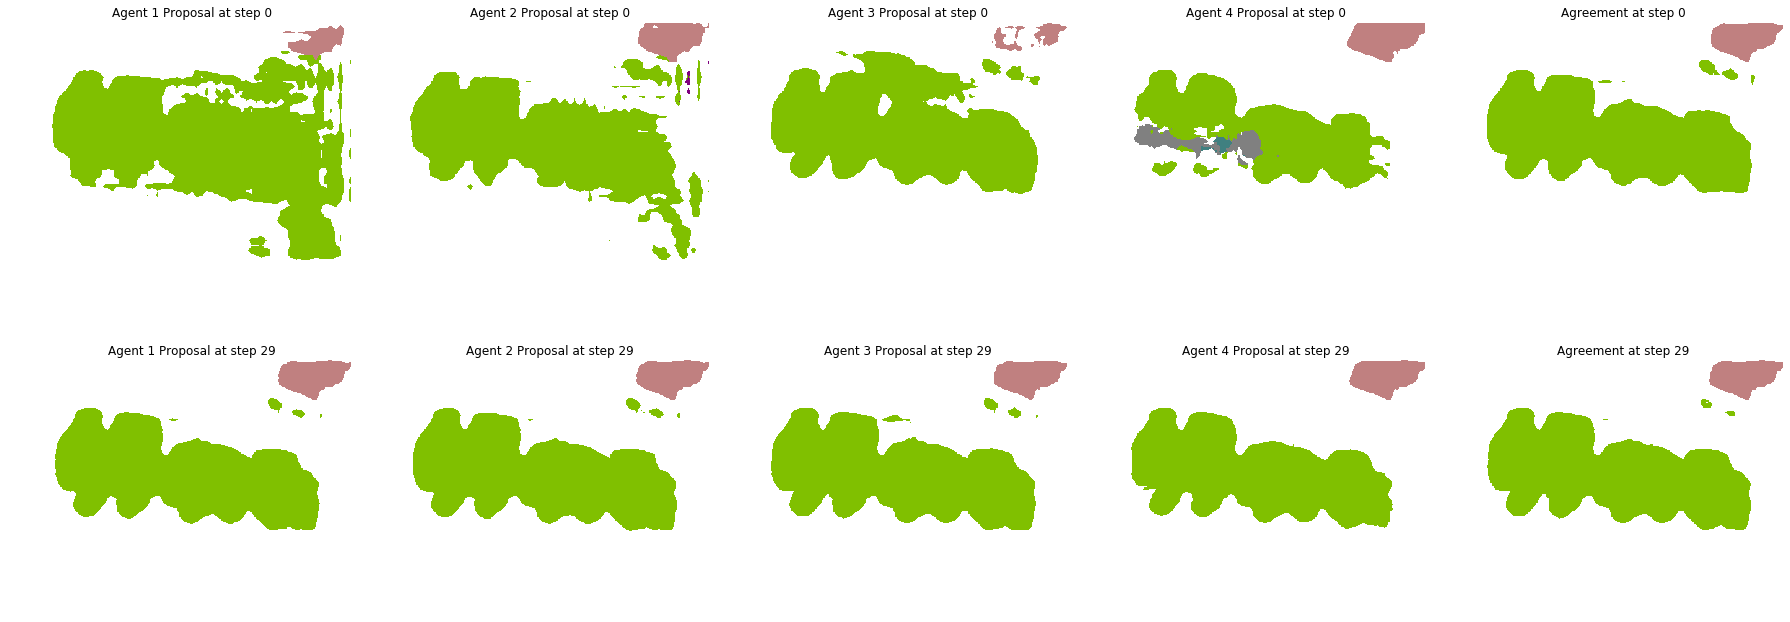

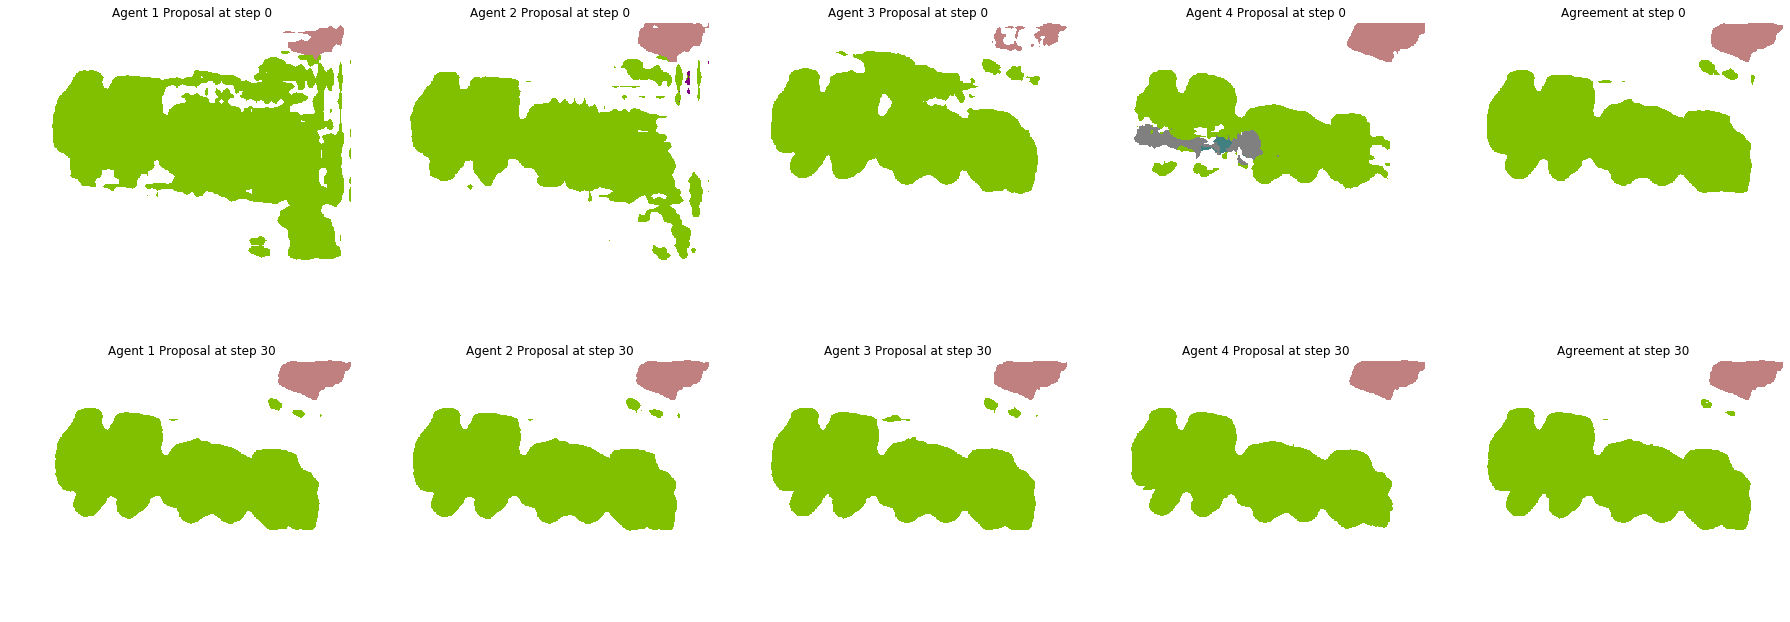

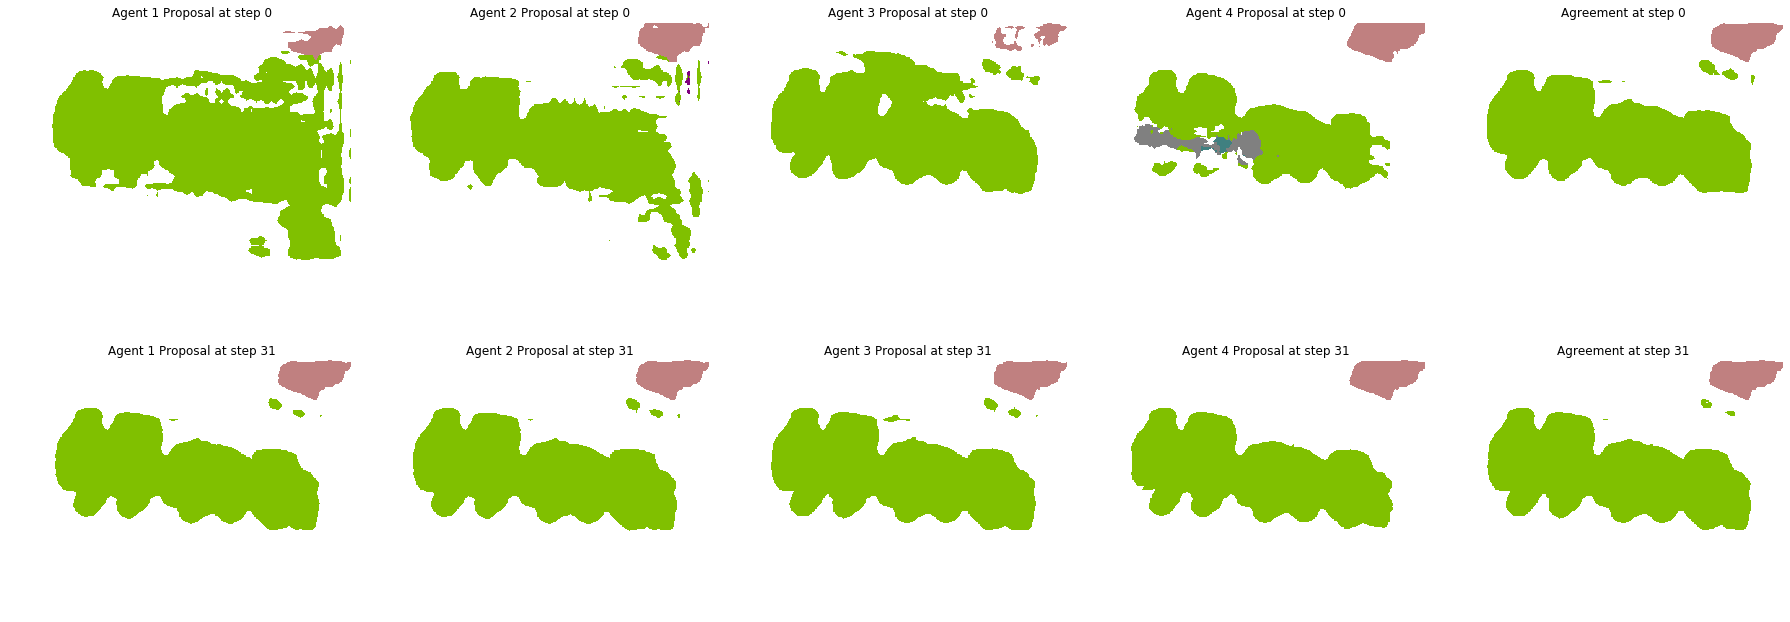

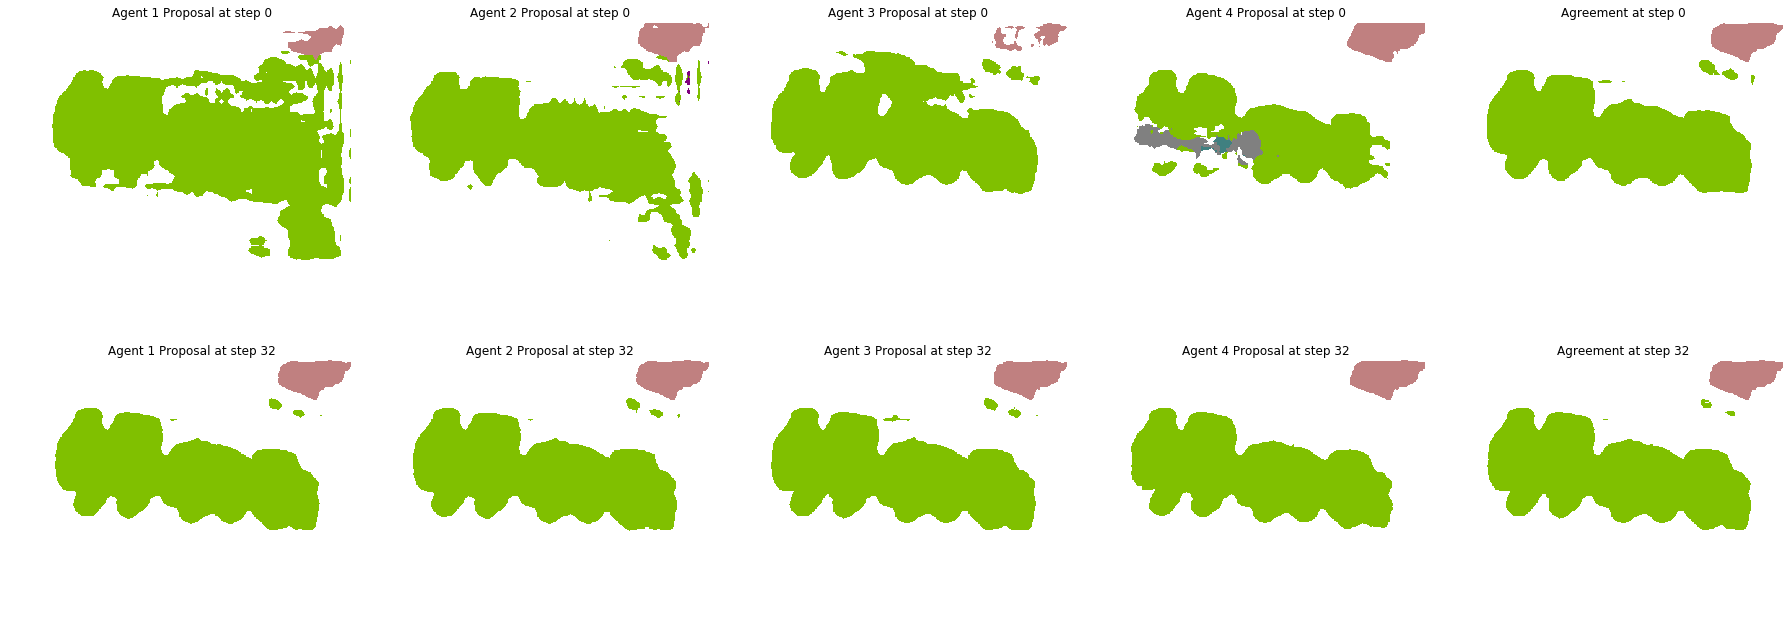

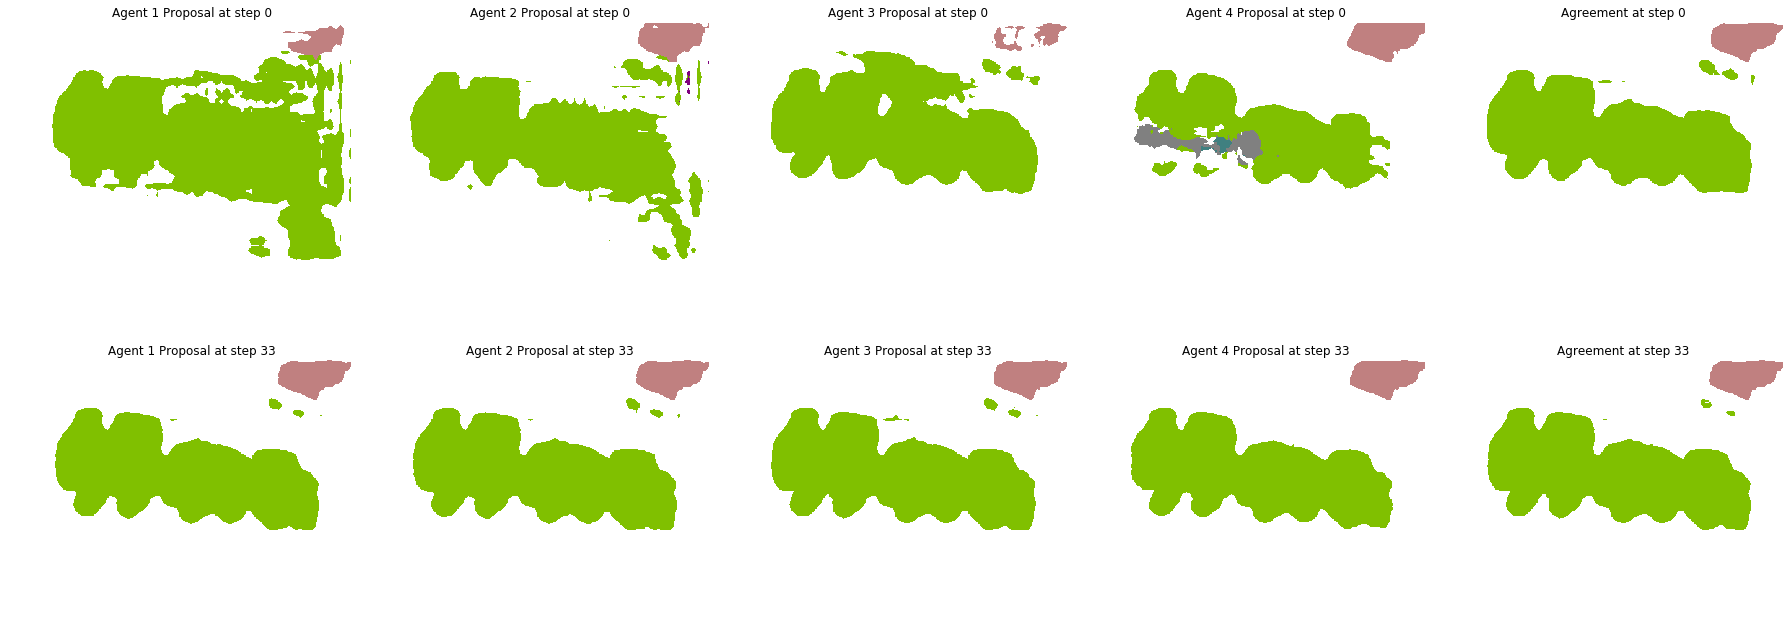

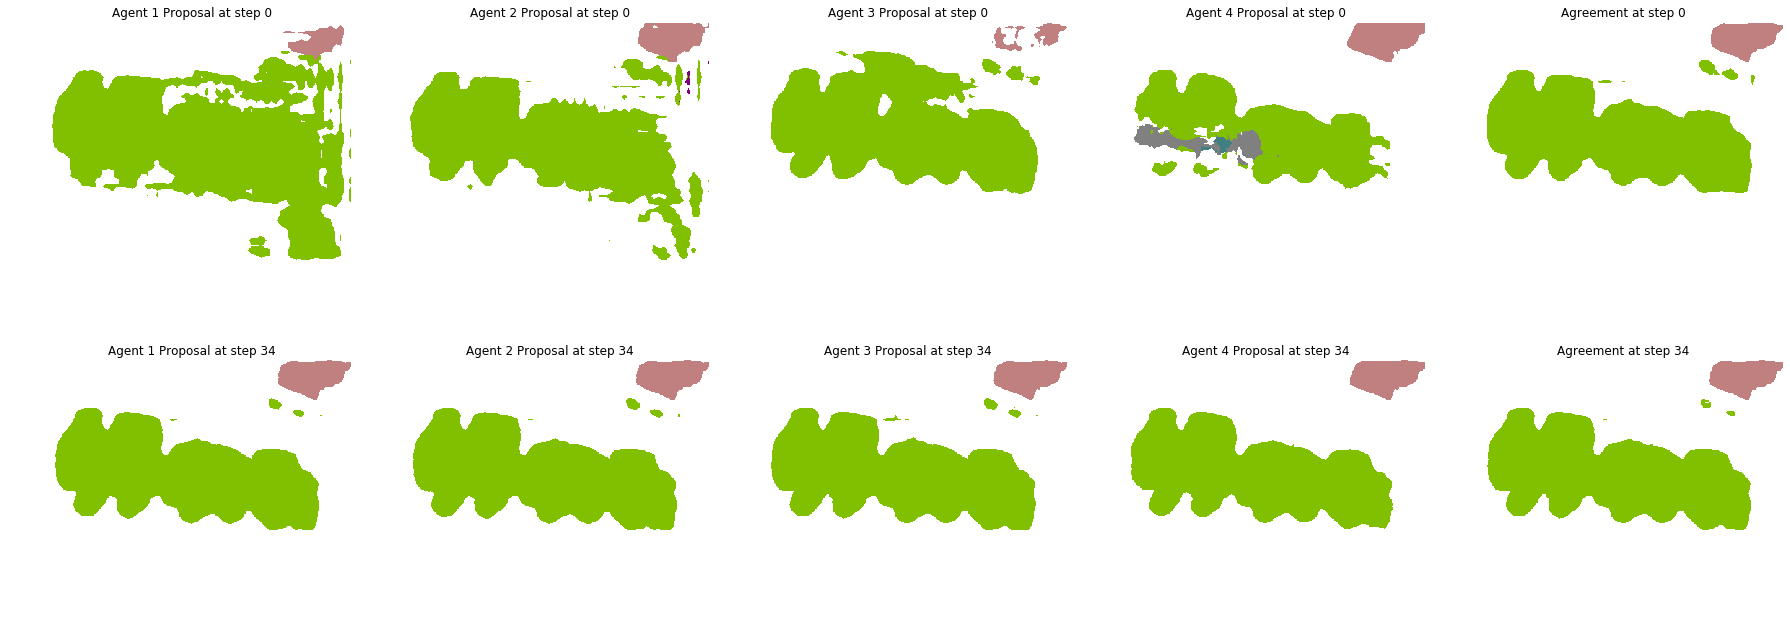

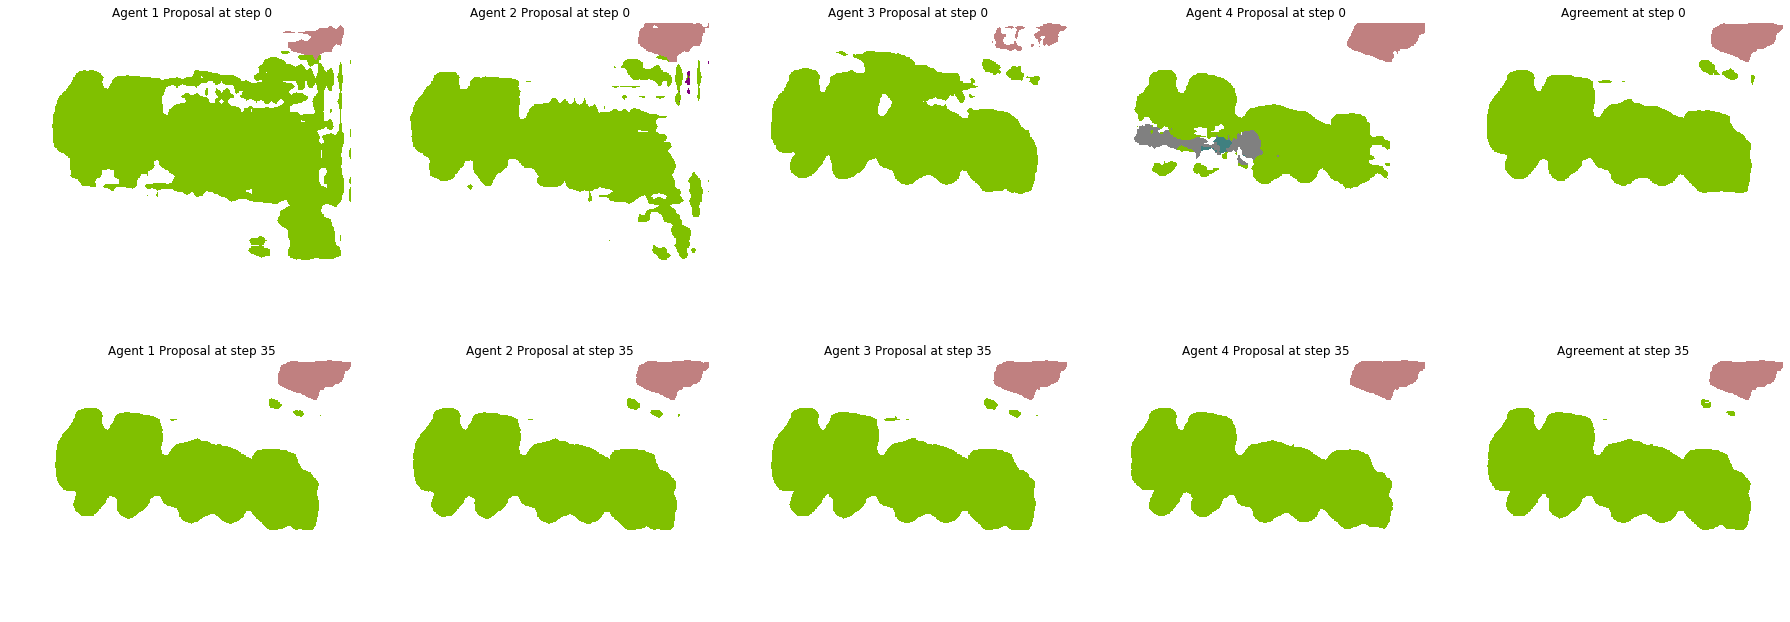

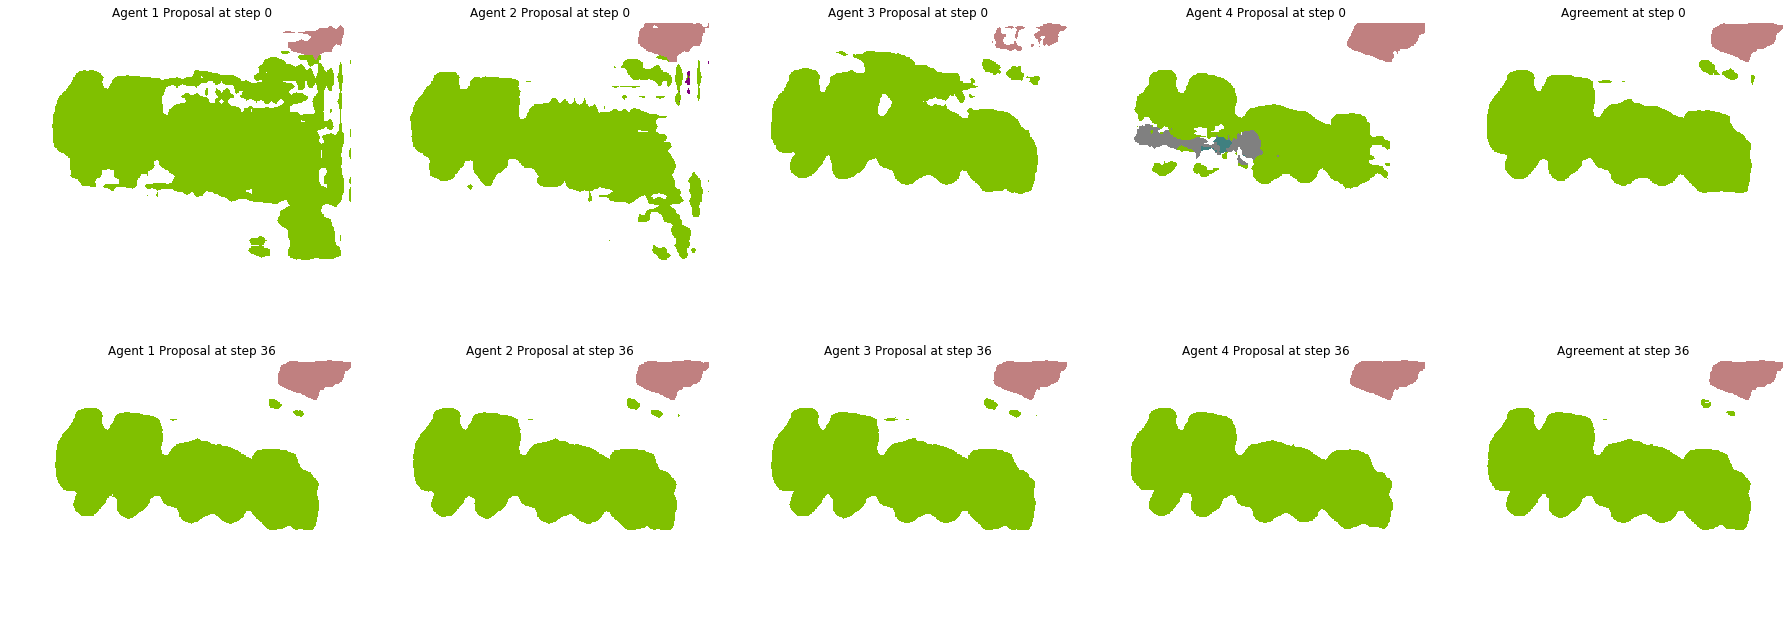

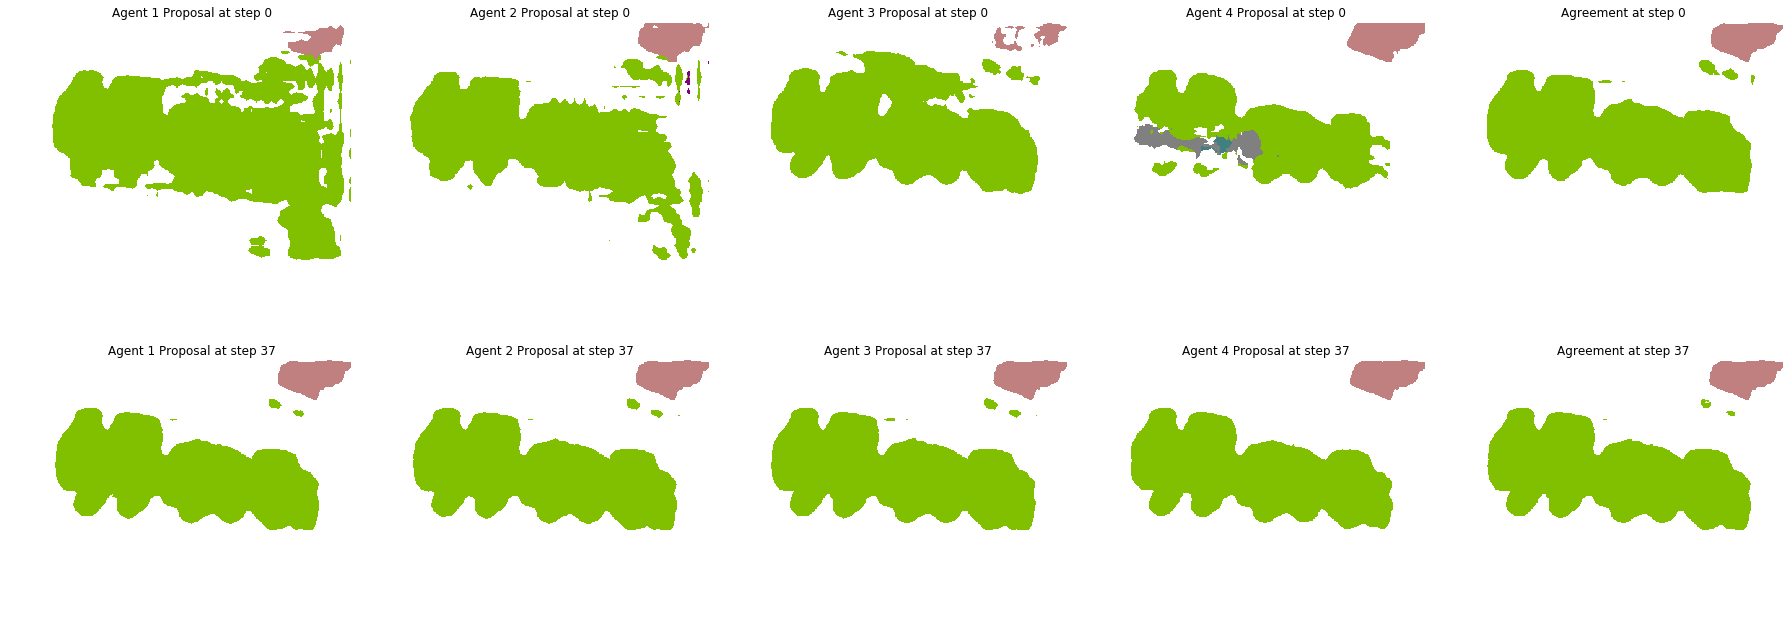

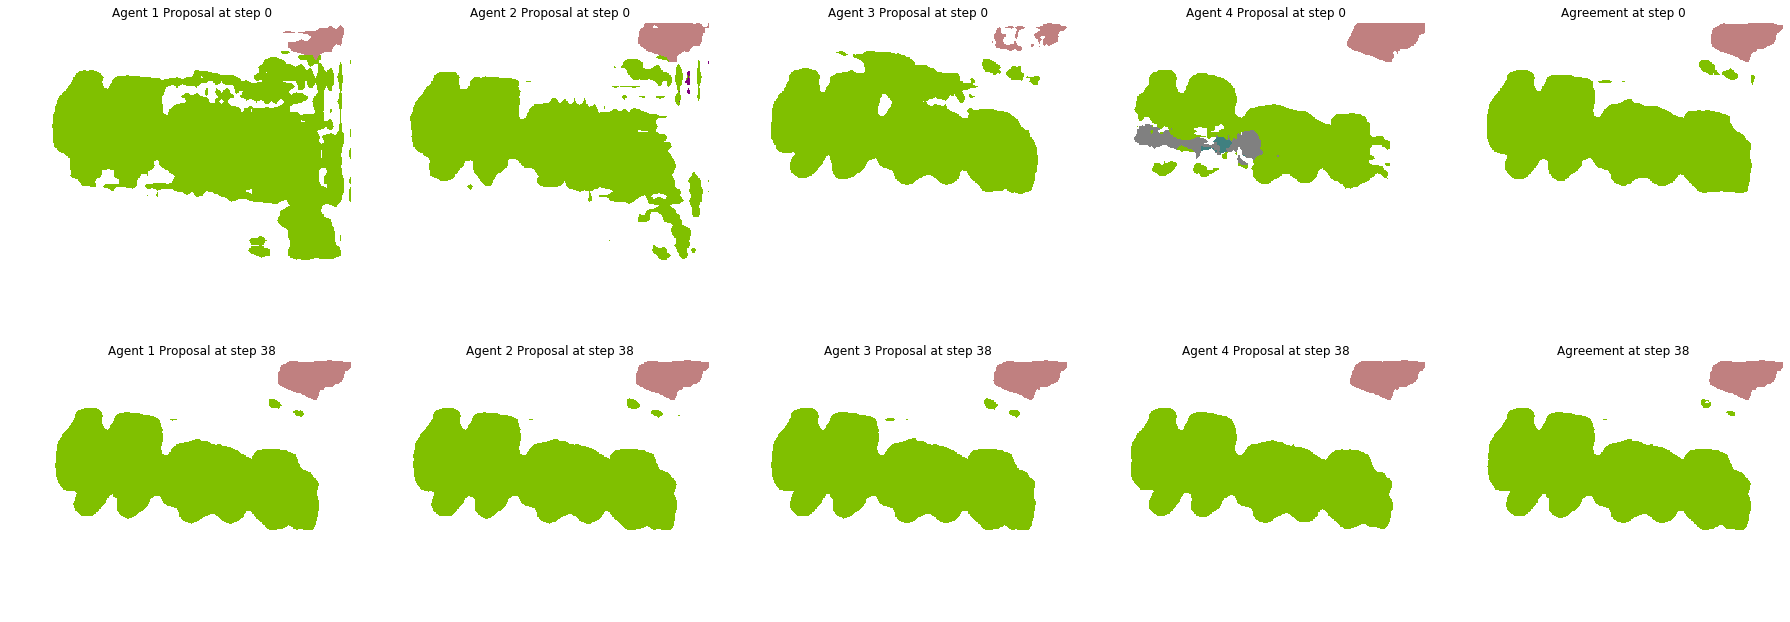

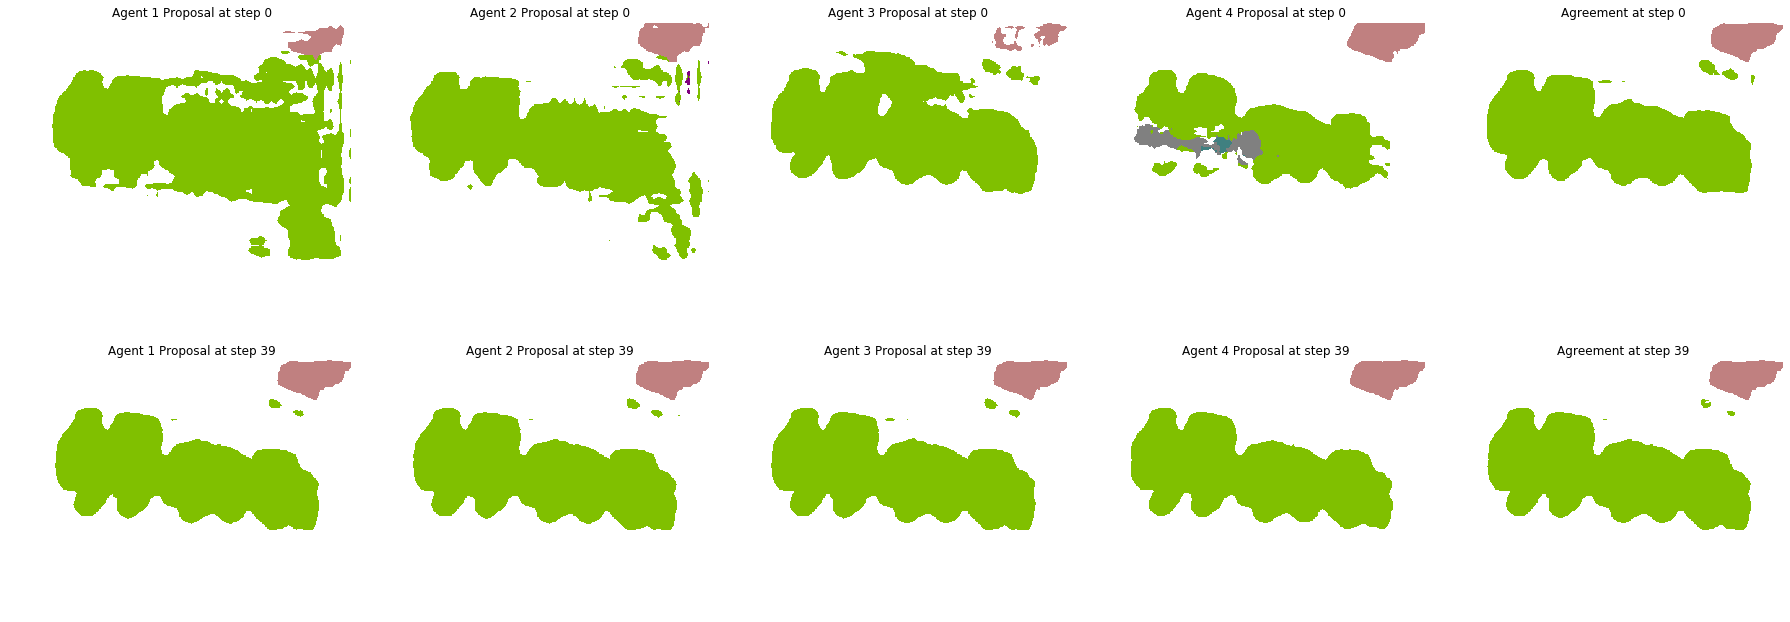

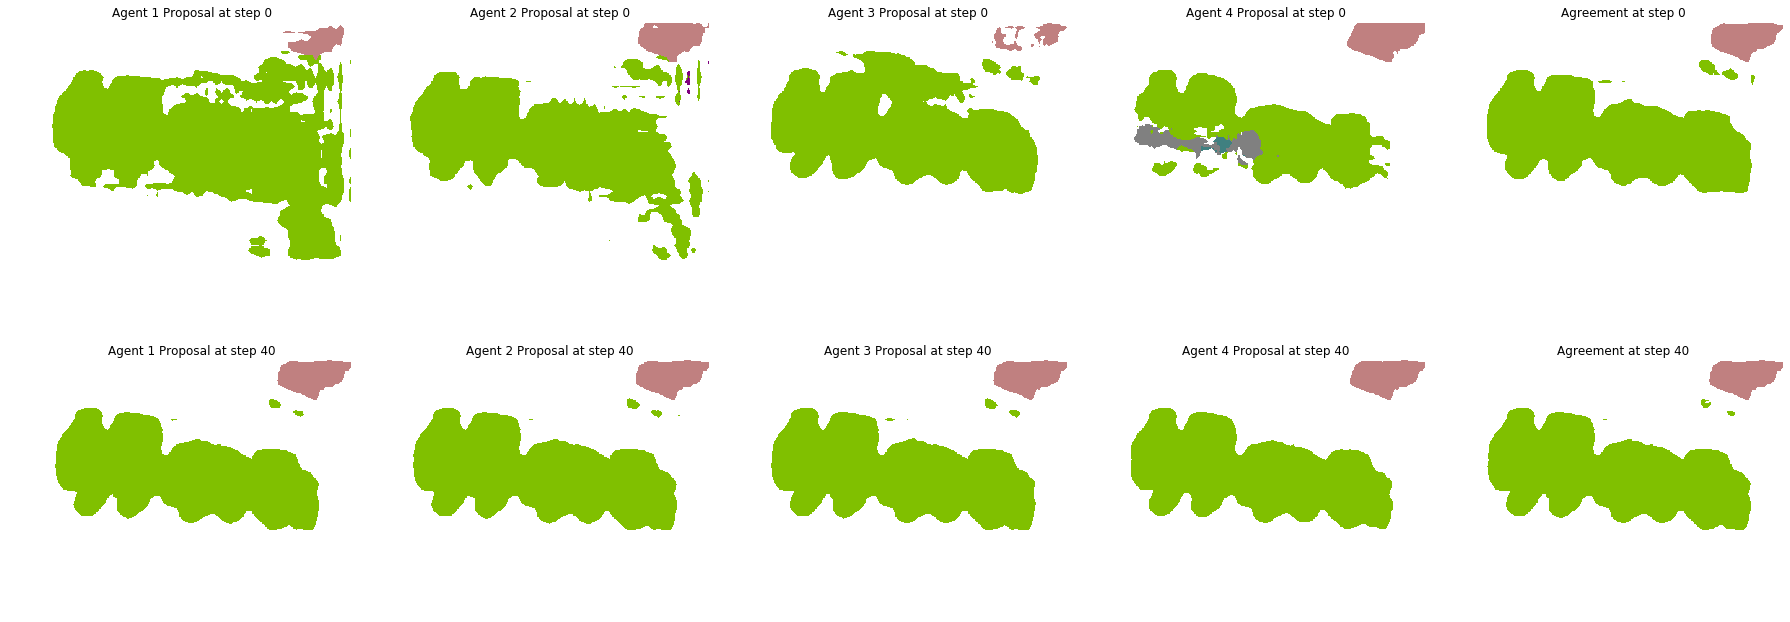

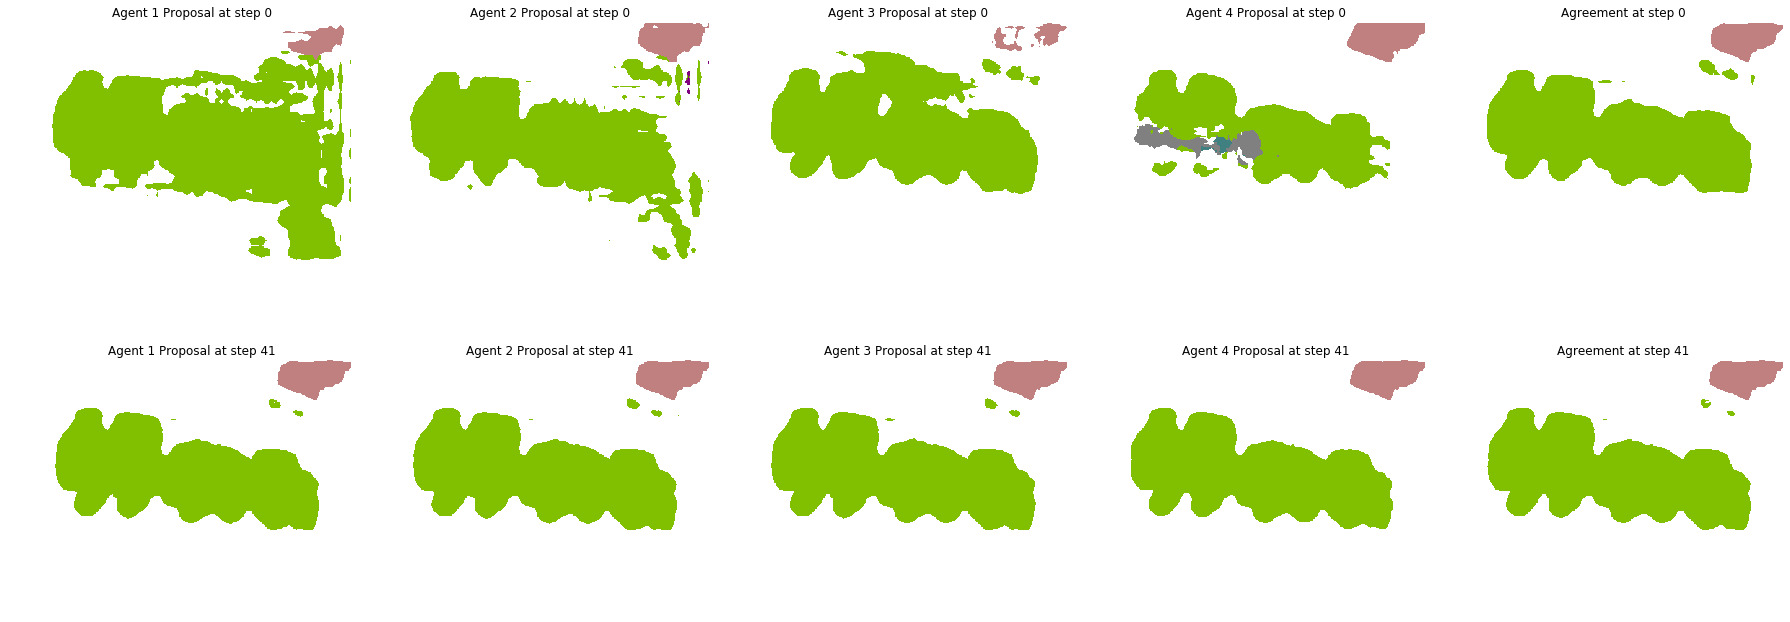

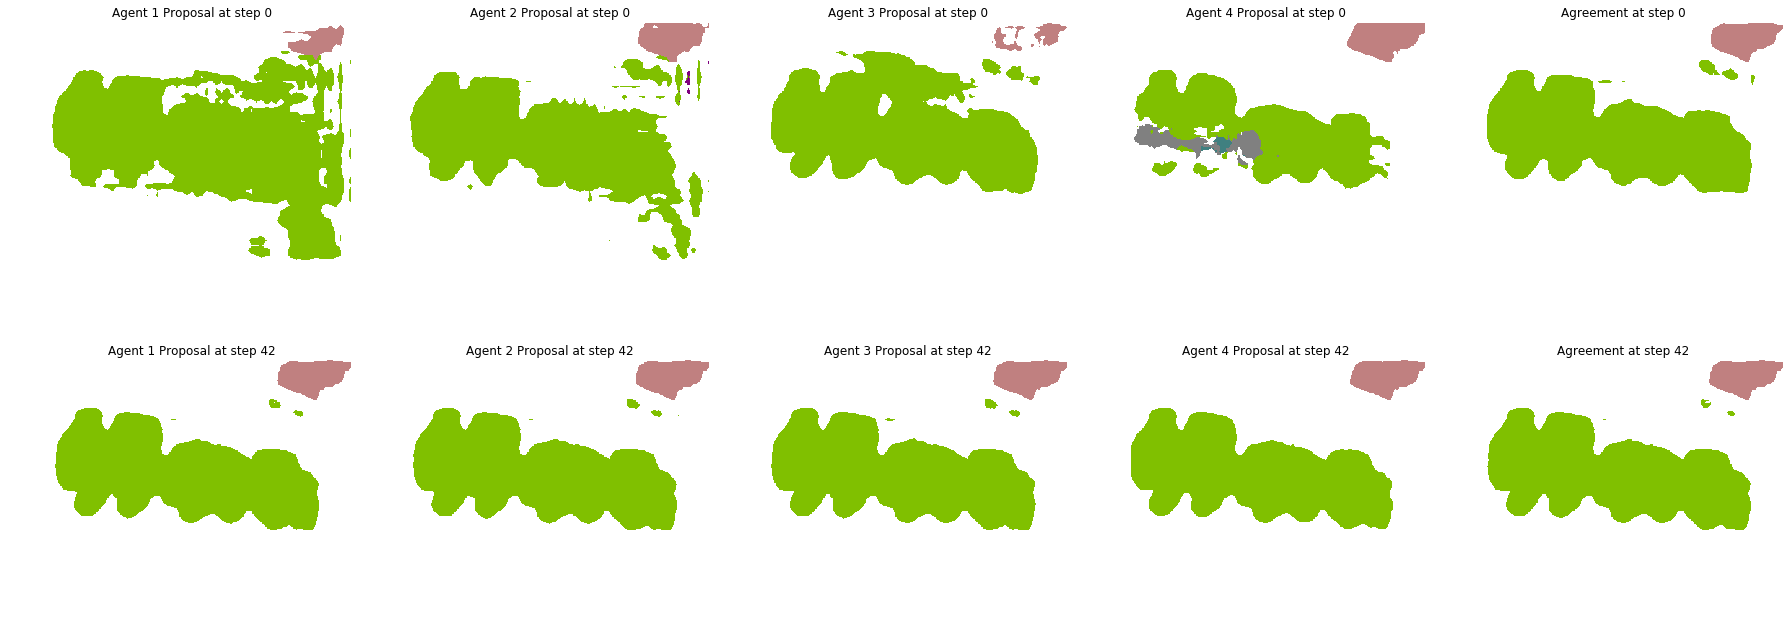

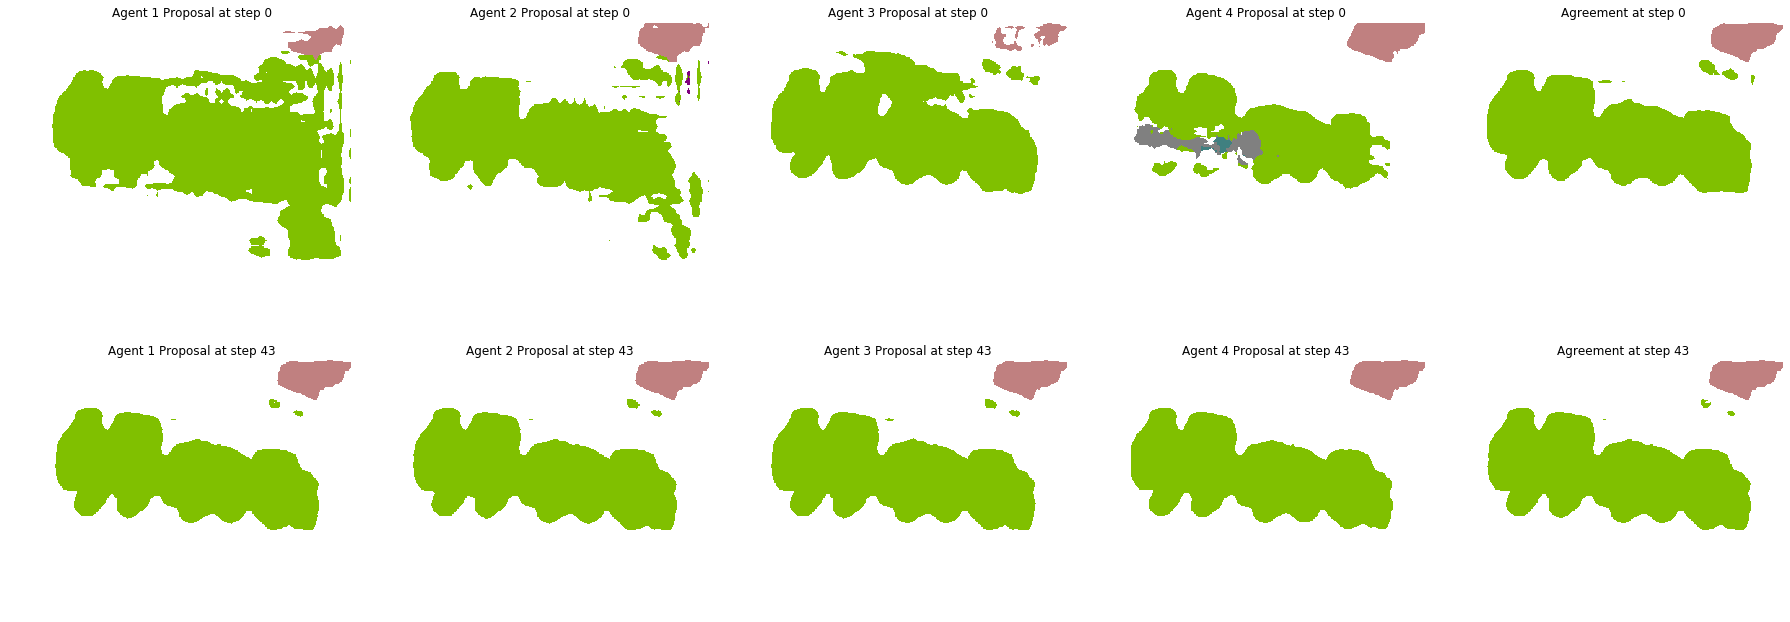

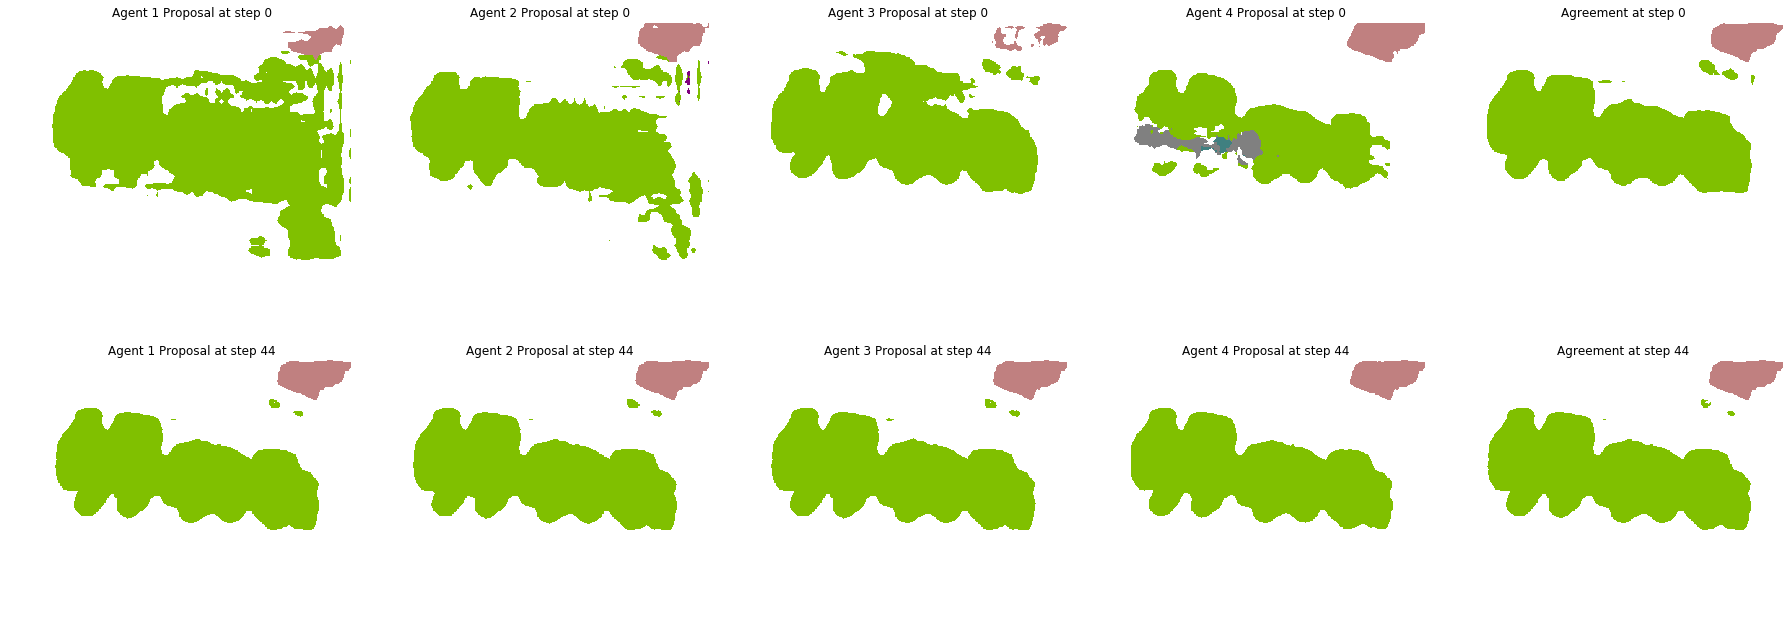

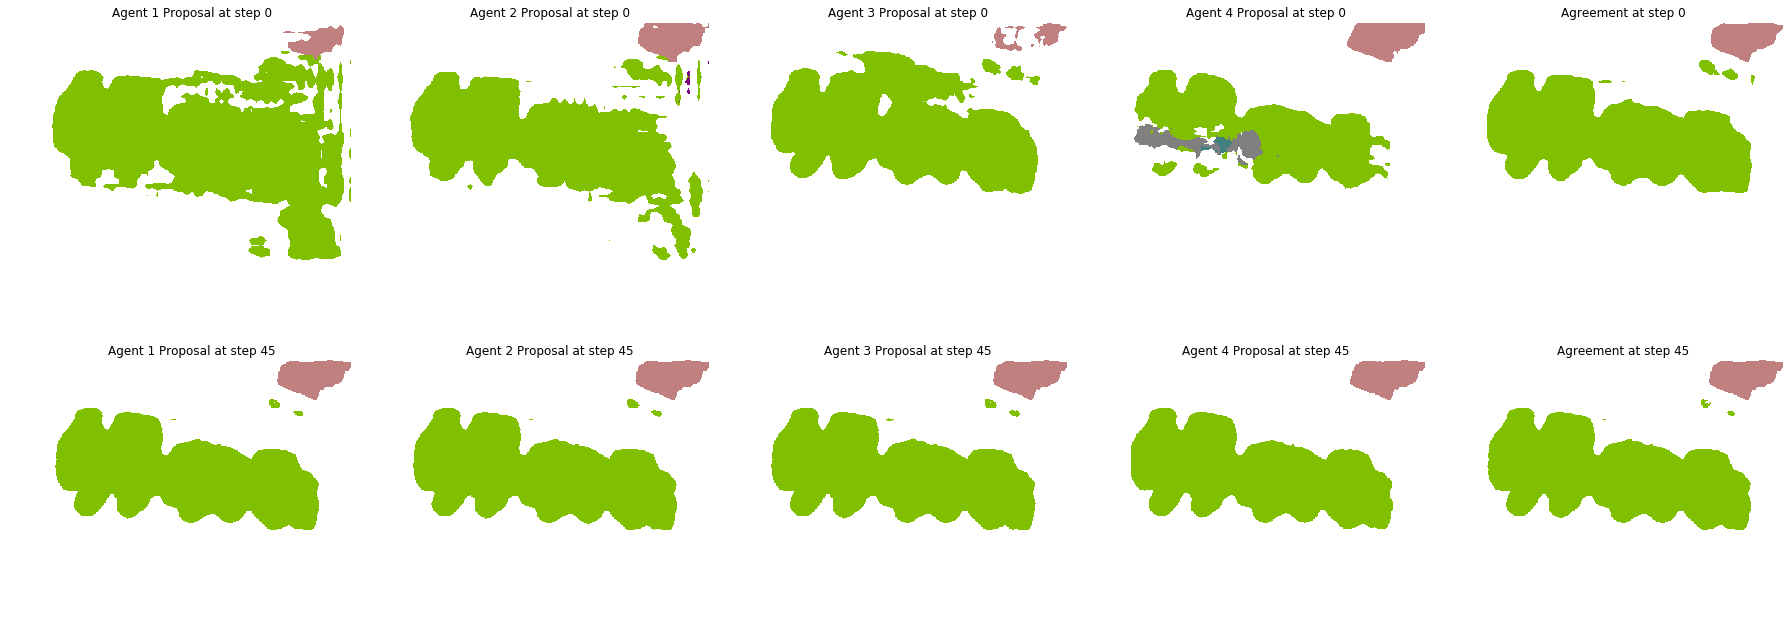

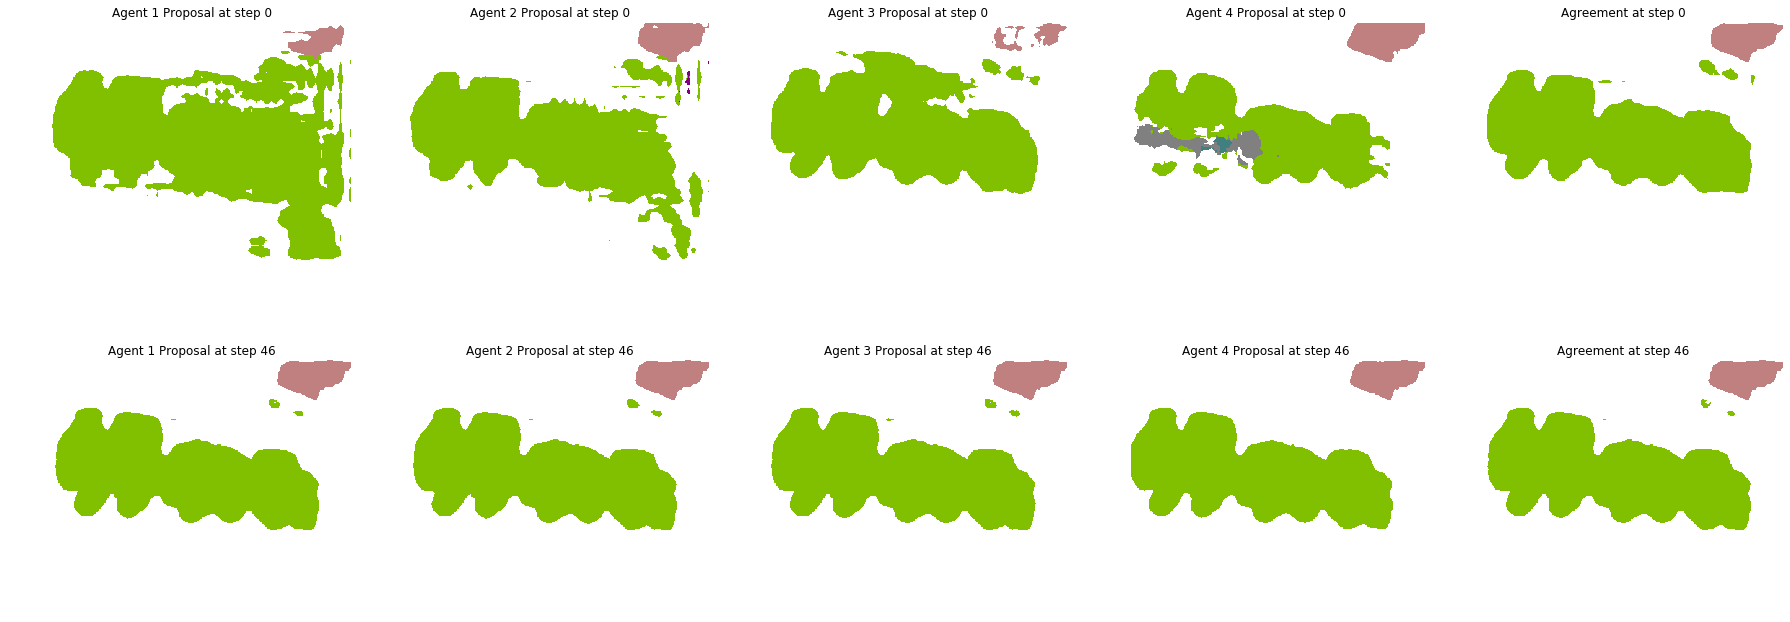

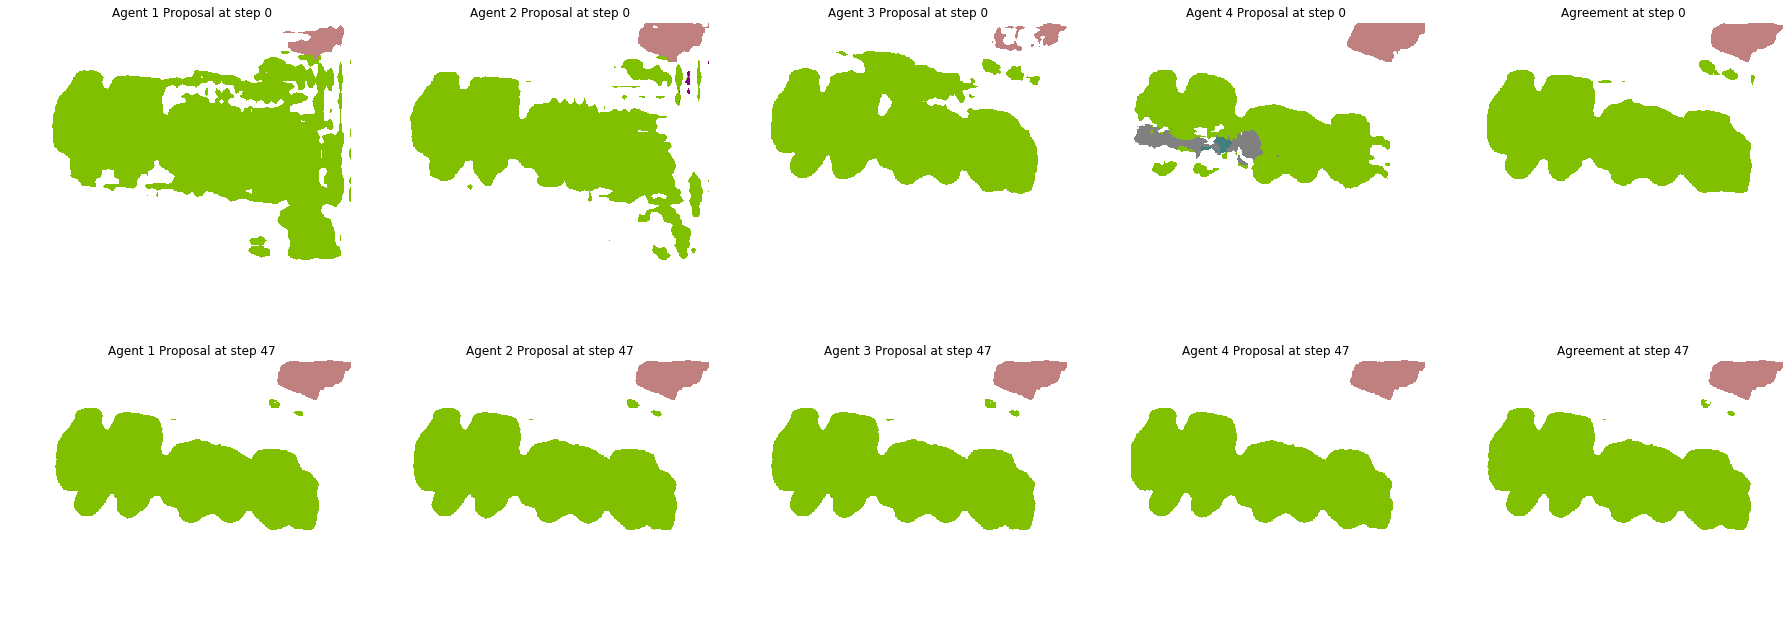

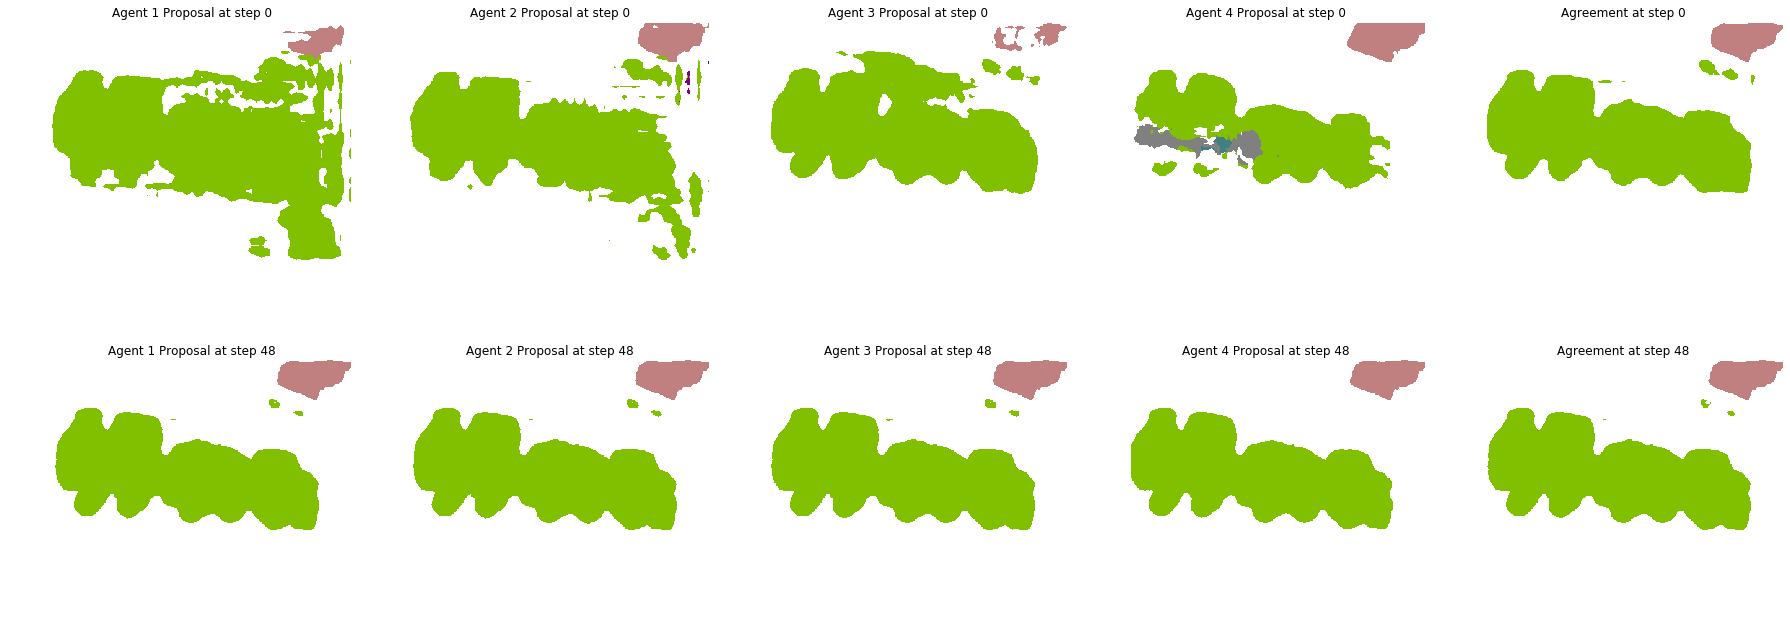

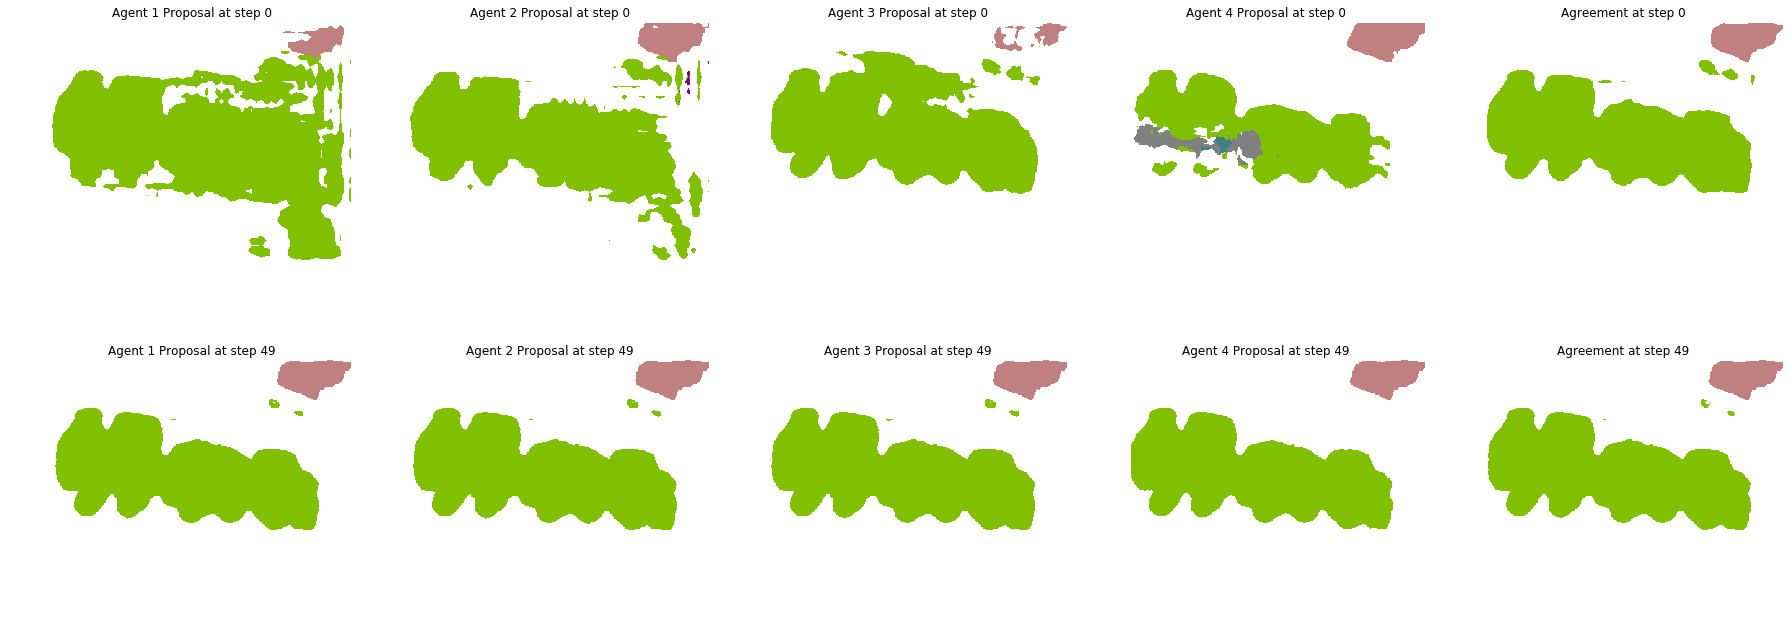

In [20]:
os.makedirs('results/gif/', exist_ok=True)
for i in range(50):
    plot_segmentations(agreements['v'], proposals['v'], step=i, task=original_im, im_alpha=0, seg_alpha=1.0).savefig('results/gif/{}.png'.format(i))

### Initial and final Agreement (Segmentation)

In [ ]:
show_agreement(agreements_v[-1], MAX_STEPS, initial=agreements_v[0])

## Dynamic comparison

In [ ]:
plot_proposals_means(proposals, agreements, show_only_labels=['person', 'train', 'horse'])


In [ ]:
# TODO: Se passo a TSNE solo le colonne dei pixel ottengo risultati molto più disordinati rispetto ad avere anche l'indice dell'agente
# TODO: Aggiungi marker di inizio e fine negoziazione

In [ ]:
view_proposals_tsne(19, proposals_v)